# Sciplex Dose

In [1]:
ood_seed = 12

In [2]:
num_ood = 1

In [3]:
obs_key = "dose_training"

In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('SAHA', '50.0'), 604)

Removed datapoint: 604


In [11]:
adata

AnnData object with n_obs × n_vars = 14207 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [13]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [14]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [15]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [16]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: ynf4pgbd
Name: mythical-wookie-453
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/ynf4pgbd
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_113136-ynf4pgbd/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1721,1579,1412,1722,1456,1546,929,1001
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 434,382,380,449,334,394,234,234
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:08<1:27:06,  8.72s/it]

Epoch 1/600:   0%|          | 1/600 [00:08<1:27:06,  8.72s/it, v_num=bd_1, total_loss_train=2.68e+3, kl_local_train=26.9]

Epoch 2/600:   0%|          | 1/600 [00:08<1:27:06,  8.72s/it, v_num=bd_1, total_loss_train=2.68e+3, kl_local_train=26.9]

Epoch 2/600:   0%|          | 2/600 [00:17<1:24:37,  8.49s/it, v_num=bd_1, total_loss_train=2.68e+3, kl_local_train=26.9]

Epoch 2/600:   0%|          | 2/600 [00:17<1:24:37,  8.49s/it, v_num=bd_1, total_loss_train=2.22e+3, kl_local_train=50.4]

Epoch 3/600:   0%|          | 2/600 [00:17<1:24:37,  8.49s/it, v_num=bd_1, total_loss_train=2.22e+3, kl_local_train=50.4]

Epoch 3/600:   0%|          | 3/600 [00:25<1:23:58,  8.44s/it, v_num=bd_1, total_loss_train=2.22e+3, kl_local_train=50.4]

Epoch 3/600:   0%|          | 3/600 [00:25<1:23:58,  8.44s/it, v_num=bd_1, total_loss_train=2.19e+3, kl_local_train=56.2]

Epoch 4/600:   0%|          | 3/600 [00:25<1:23:58,  8.44s/it, v_num=bd_1, total_loss_train=2.19e+3, kl_local_train=56.2]

Epoch 4/600:   1%|          | 4/600 [00:33<1:23:35,  8.41s/it, v_num=bd_1, total_loss_train=2.19e+3, kl_local_train=56.2]

Epoch 4/600:   1%|          | 4/600 [00:33<1:23:35,  8.41s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=58.2]

Epoch 5/600:   1%|          | 4/600 [00:33<1:23:35,  8.41s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=58.2]

Epoch 5/600:   1%|          | 5/600 [00:42<1:25:31,  8.62s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=58.2]

Epoch 5/600:   1%|          | 5/600 [00:42<1:25:31,  8.62s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=58]  

Epoch 6/600:   1%|          | 5/600 [00:43<1:25:31,  8.62s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=58]

Epoch 6/600:   1%|          | 6/600 [00:50<1:23:38,  8.45s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=58]

Epoch 6/600:   1%|          | 6/600 [00:50<1:23:38,  8.45s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 7/600:   1%|          | 6/600 [00:50<1:23:38,  8.45s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 7/600:   1%|          | 7/600 [00:58<1:20:50,  8.18s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 7/600:   1%|          | 7/600 [00:58<1:20:50,  8.18s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 8/600:   1%|          | 7/600 [00:58<1:20:50,  8.18s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 8/600:   1%|▏         | 8/600 [01:06<1:19:01,  8.01s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=53.2, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 8/600:   1%|▏         | 8/600 [01:06<1:19:01,  8.01s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 9/600:   1%|▏         | 8/600 [01:06<1:19:01,  8.01s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 9/600:   2%|▏         | 9/600 [01:13<1:17:41,  7.89s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 9/600:   2%|▏         | 9/600 [01:13<1:17:41,  7.89s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 10/600:   2%|▏         | 9/600 [01:13<1:17:41,  7.89s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 10/600:   2%|▏         | 10/600 [01:22<1:19:11,  8.05s/it, v_num=bd_1, total_loss_train=2.18e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 10/600:   2%|▏         | 10/600 [01:22<1:19:11,  8.05s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 11/600:   2%|▏         | 10/600 [01:22<1:19:11,  8.05s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 11/600:   2%|▏         | 11/600 [01:30<1:18:53,  8.04s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0397, metric_mi|condition_train=0.0295]

Epoch 11/600:   2%|▏         | 11/600 [01:30<1:18:53,  8.04s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 12/600:   2%|▏         | 11/600 [01:30<1:18:53,  8.04s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 12/600:   2%|▏         | 12/600 [01:37<1:17:20,  7.89s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 12/600:   2%|▏         | 12/600 [01:37<1:17:20,  7.89s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 13/600:   2%|▏         | 12/600 [01:37<1:17:20,  7.89s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 13/600:   2%|▏         | 13/600 [01:45<1:16:19,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 13/600:   2%|▏         | 13/600 [01:45<1:16:19,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 14/600:   2%|▏         | 13/600 [01:45<1:16:19,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 14/600:   2%|▏         | 14/600 [01:52<1:15:31,  7.73s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 14/600:   2%|▏         | 14/600 [01:52<1:15:31,  7.73s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]  

Epoch 15/600:   2%|▏         | 14/600 [01:52<1:15:31,  7.73s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 15/600:   2%|▎         | 15/600 [02:00<1:15:56,  7.79s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 15/600:   2%|▎         | 15/600 [02:00<1:15:56,  7.79s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 16/600:   2%|▎         | 15/600 [02:01<1:15:56,  7.79s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 16/600:   3%|▎         | 16/600 [02:08<1:16:47,  7.89s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0504, metric_mi|condition_train=0.0915]

Epoch 16/600:   3%|▎         | 16/600 [02:08<1:16:47,  7.89s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132] 

Epoch 17/600:   3%|▎         | 16/600 [02:09<1:16:47,  7.89s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 17/600:   3%|▎         | 17/600 [02:16<1:16:08,  7.84s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 17/600:   3%|▎         | 17/600 [02:16<1:16:08,  7.84s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 18/600:   3%|▎         | 17/600 [02:16<1:16:08,  7.84s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 18/600:   3%|▎         | 18/600 [02:24<1:15:37,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 18/600:   3%|▎         | 18/600 [02:24<1:15:37,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 19/600:   3%|▎         | 18/600 [02:24<1:15:37,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 19/600:   3%|▎         | 19/600 [02:32<1:15:17,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 19/600:   3%|▎         | 19/600 [02:32<1:15:17,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 20/600:   3%|▎         | 19/600 [02:32<1:15:17,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 20/600:   3%|▎         | 20/600 [02:40<1:16:31,  7.92s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 20/600:   3%|▎         | 20/600 [02:40<1:16:31,  7.92s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=35, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]  

Epoch 21/600:   3%|▎         | 20/600 [02:40<1:16:31,  7.92s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=35, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 21/600:   4%|▎         | 21/600 [02:48<1:17:10,  8.00s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=35, metric_mi|dose_training_train=0.0592, metric_mi|condition_train=0.132]

Epoch 21/600:   4%|▎         | 21/600 [02:48<1:17:10,  8.00s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 22/600:   4%|▎         | 21/600 [02:48<1:17:10,  8.00s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 22/600:   4%|▎         | 22/600 [02:56<1:16:12,  7.91s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36.1, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 22/600:   4%|▎         | 22/600 [02:56<1:16:12,  7.91s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 23/600:   4%|▎         | 22/600 [02:56<1:16:12,  7.91s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 23/600:   4%|▍         | 23/600 [03:03<1:15:27,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 23/600:   4%|▍         | 23/600 [03:03<1:15:27,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 24/600:   4%|▍         | 23/600 [03:03<1:15:27,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 24/600:   4%|▍         | 24/600 [03:11<1:14:51,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 24/600:   4%|▍         | 24/600 [03:11<1:14:51,  7.80s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 25/600:   4%|▍         | 24/600 [03:11<1:14:51,  7.80s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 25/600:   4%|▍         | 25/600 [03:19<1:15:54,  7.92s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 25/600:   4%|▍         | 25/600 [03:19<1:15:54,  7.92s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 26/600:   4%|▍         | 25/600 [03:20<1:15:54,  7.92s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 26/600:   4%|▍         | 26/600 [03:27<1:16:13,  7.97s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0591, metric_mi|condition_train=0.118]

Epoch 26/600:   4%|▍         | 26/600 [03:27<1:16:13,  7.97s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 27/600:   4%|▍         | 26/600 [03:27<1:16:13,  7.97s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 27/600:   4%|▍         | 27/600 [03:35<1:15:14,  7.88s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 27/600:   4%|▍         | 27/600 [03:35<1:15:14,  7.88s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 28/600:   4%|▍         | 27/600 [03:35<1:15:14,  7.88s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 28/600:   5%|▍         | 28/600 [03:43<1:14:26,  7.81s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=37.9, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 28/600:   5%|▍         | 28/600 [03:43<1:14:26,  7.81s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 29/600:   5%|▍         | 28/600 [03:43<1:14:26,  7.81s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 29/600:   5%|▍         | 29/600 [03:50<1:13:54,  7.77s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 29/600:   5%|▍         | 29/600 [03:50<1:13:54,  7.77s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 30/600:   5%|▍         | 29/600 [03:50<1:13:54,  7.77s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 30/600:   5%|▌         | 30/600 [03:59<1:15:56,  7.99s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 30/600:   5%|▌         | 30/600 [03:59<1:15:56,  7.99s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 31/600:   5%|▌         | 30/600 [03:59<1:15:56,  7.99s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 31/600:   5%|▌         | 31/600 [04:07<1:16:03,  8.02s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0581, metric_mi|condition_train=0.108]

Epoch 31/600:   5%|▌         | 31/600 [04:07<1:16:03,  8.02s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 32/600:   5%|▌         | 31/600 [04:07<1:16:03,  8.02s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 32/600:   5%|▌         | 32/600 [04:15<1:15:01,  7.93s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=43.6, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 32/600:   5%|▌         | 32/600 [04:15<1:15:01,  7.93s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 33/600:   5%|▌         | 32/600 [04:15<1:15:01,  7.93s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 33/600:   6%|▌         | 33/600 [04:23<1:14:29,  7.88s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 33/600:   6%|▌         | 33/600 [04:23<1:14:29,  7.88s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 34/600:   6%|▌         | 33/600 [04:23<1:14:29,  7.88s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 34/600:   6%|▌         | 34/600 [04:30<1:14:04,  7.85s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 34/600:   6%|▌         | 34/600 [04:30<1:14:04,  7.85s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 35/600:   6%|▌         | 34/600 [04:30<1:14:04,  7.85s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 35/600:   6%|▌         | 35/600 [04:38<1:14:42,  7.93s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=47.1, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 35/600:   6%|▌         | 35/600 [04:38<1:14:42,  7.93s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 36/600:   6%|▌         | 35/600 [04:39<1:14:42,  7.93s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 36/600:   6%|▌         | 36/600 [04:46<1:14:53,  7.97s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.0599, metric_mi|condition_train=0.105]

Epoch 36/600:   6%|▌         | 36/600 [04:46<1:14:53,  7.97s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 37/600:   6%|▌         | 36/600 [04:46<1:14:53,  7.97s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 37/600:   6%|▌         | 37/600 [04:54<1:13:38,  7.85s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 37/600:   6%|▌         | 37/600 [04:54<1:13:38,  7.85s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 38/600:   6%|▌         | 37/600 [04:54<1:13:38,  7.85s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 38/600:   6%|▋         | 38/600 [05:02<1:12:40,  7.76s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 38/600:   6%|▋         | 38/600 [05:02<1:12:40,  7.76s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 39/600:   6%|▋         | 38/600 [05:02<1:12:40,  7.76s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 39/600:   6%|▋         | 39/600 [05:09<1:11:54,  7.69s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 39/600:   6%|▋         | 39/600 [05:09<1:11:54,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 40/600:   6%|▋         | 39/600 [05:09<1:11:54,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 40/600:   7%|▋         | 40/600 [05:17<1:12:04,  7.72s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 40/600:   7%|▋         | 40/600 [05:17<1:12:04,  7.72s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 41/600:   7%|▋         | 40/600 [05:17<1:12:04,  7.72s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 41/600:   7%|▋         | 41/600 [05:25<1:12:40,  7.80s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=48.6, metric_mi|dose_training_train=0.062, metric_mi|condition_train=0.0988]

Epoch 41/600:   7%|▋         | 41/600 [05:25<1:12:40,  7.80s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 42/600:   7%|▋         | 41/600 [05:25<1:12:40,  7.80s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 42/600:   7%|▋         | 42/600 [05:32<1:11:53,  7.73s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.4, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 42/600:   7%|▋         | 42/600 [05:32<1:11:53,  7.73s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 43/600:   7%|▋         | 42/600 [05:32<1:11:53,  7.73s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 43/600:   7%|▋         | 43/600 [05:40<1:11:16,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 43/600:   7%|▋         | 43/600 [05:40<1:11:16,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 44/600:   7%|▋         | 43/600 [05:40<1:11:16,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 44/600:   7%|▋         | 44/600 [05:48<1:10:49,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 44/600:   7%|▋         | 44/600 [05:48<1:10:49,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 45/600:   7%|▋         | 44/600 [05:48<1:10:49,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 45/600:   8%|▊         | 45/600 [05:55<1:11:02,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 45/600:   8%|▊         | 45/600 [05:55<1:11:02,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]  

Epoch 46/600:   8%|▊         | 45/600 [05:56<1:11:02,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 46/600:   8%|▊         | 46/600 [06:03<1:11:39,  7.76s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=51, metric_mi|dose_training_train=0.0628, metric_mi|condition_train=0.0944]

Epoch 46/600:   8%|▊         | 46/600 [06:03<1:11:39,  7.76s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 47/600:   8%|▊         | 46/600 [06:03<1:11:39,  7.76s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 47/600:   8%|▊         | 47/600 [06:11<1:10:53,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 47/600:   8%|▊         | 47/600 [06:11<1:10:53,  7.69s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 48/600:   8%|▊         | 47/600 [06:11<1:10:53,  7.69s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 48/600:   8%|▊         | 48/600 [06:18<1:10:17,  7.64s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 48/600:   8%|▊         | 48/600 [06:18<1:10:17,  7.64s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 49/600:   8%|▊         | 48/600 [06:18<1:10:17,  7.64s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 49/600:   8%|▊         | 49/600 [06:26<1:09:51,  7.61s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 49/600:   8%|▊         | 49/600 [06:26<1:09:51,  7.61s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 50/600:   8%|▊         | 49/600 [06:26<1:09:51,  7.61s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 50/600:   8%|▊         | 50/600 [06:34<1:10:07,  7.65s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 50/600:   8%|▊         | 50/600 [06:34<1:10:07,  7.65s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 51/600:   8%|▊         | 50/600 [06:34<1:10:07,  7.65s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 51/600:   8%|▊         | 51/600 [06:42<1:10:49,  7.74s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0915]

Epoch 51/600:   8%|▊         | 51/600 [06:42<1:10:49,  7.74s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 52/600:   8%|▊         | 51/600 [06:42<1:10:49,  7.74s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 52/600:   9%|▊         | 52/600 [06:49<1:10:06,  7.68s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=55.3, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 52/600:   9%|▊         | 52/600 [06:49<1:10:06,  7.68s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 53/600:   9%|▊         | 52/600 [06:49<1:10:06,  7.68s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 53/600:   9%|▉         | 53/600 [06:57<1:09:33,  7.63s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 53/600:   9%|▉         | 53/600 [06:57<1:09:33,  7.63s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 54/600:   9%|▉         | 53/600 [06:57<1:09:33,  7.63s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 54/600:   9%|▉         | 54/600 [07:04<1:09:11,  7.60s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=56.9, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 54/600:   9%|▉         | 54/600 [07:04<1:09:11,  7.60s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 55/600:   9%|▉         | 54/600 [07:04<1:09:11,  7.60s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 55/600:   9%|▉         | 55/600 [07:12<1:09:28,  7.65s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=57.2, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 55/600:   9%|▉         | 55/600 [07:12<1:09:28,  7.65s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 56/600:   9%|▉         | 55/600 [07:12<1:09:28,  7.65s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 56/600:   9%|▉         | 56/600 [07:20<1:10:13,  7.74s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0621, metric_mi|condition_train=0.0882]

Epoch 56/600:   9%|▉         | 56/600 [07:20<1:10:13,  7.74s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 57/600:   9%|▉         | 56/600 [07:20<1:10:13,  7.74s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 57/600:  10%|▉         | 57/600 [07:27<1:09:30,  7.68s/it, v_num=bd_1, total_loss_train=2.17e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 57/600:  10%|▉         | 57/600 [07:27<1:09:30,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 58/600:  10%|▉         | 57/600 [07:27<1:09:30,  7.68s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 58/600:  10%|▉         | 58/600 [07:35<1:09:00,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=59.1, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 58/600:  10%|▉         | 58/600 [07:35<1:09:00,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=58, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]  

Epoch 59/600:  10%|▉         | 58/600 [07:35<1:09:00,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=58, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 59/600:  10%|▉         | 59/600 [07:43<1:08:35,  7.61s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=58, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 59/600:  10%|▉         | 59/600 [07:43<1:08:35,  7.61s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 60/600:  10%|▉         | 59/600 [07:43<1:08:35,  7.61s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 60/600:  10%|█         | 60/600 [07:50<1:08:49,  7.65s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=57.4, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 60/600:  10%|█         | 60/600 [07:50<1:08:49,  7.65s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 61/600:  10%|█         | 60/600 [07:51<1:08:49,  7.65s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 61/600:  10%|█         | 61/600 [07:58<1:09:33,  7.74s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=56.5, metric_mi|dose_training_train=0.0623, metric_mi|condition_train=0.0846]

Epoch 61/600:  10%|█         | 61/600 [07:58<1:09:33,  7.74s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 62/600:  10%|█         | 61/600 [07:58<1:09:33,  7.74s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 62/600:  10%|█         | 62/600 [08:06<1:08:56,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=56.8, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 62/600:  10%|█         | 62/600 [08:06<1:08:56,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 63/600:  10%|█         | 62/600 [08:06<1:08:56,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 63/600:  10%|█         | 63/600 [08:13<1:08:27,  7.65s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 63/600:  10%|█         | 63/600 [08:13<1:08:27,  7.65s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 64/600:  10%|█         | 63/600 [08:13<1:08:27,  7.65s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 64/600:  11%|█         | 64/600 [08:21<1:08:05,  7.62s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 64/600:  11%|█         | 64/600 [08:21<1:08:05,  7.62s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 65/600:  11%|█         | 64/600 [08:21<1:08:05,  7.62s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 65/600:  11%|█         | 65/600 [08:29<1:08:20,  7.66s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 65/600:  11%|█         | 65/600 [08:29<1:08:20,  7.66s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 66/600:  11%|█         | 65/600 [08:29<1:08:20,  7.66s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 66/600:  11%|█         | 66/600 [08:37<1:08:57,  7.75s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.0811]

Epoch 66/600:  11%|█         | 66/600 [08:37<1:08:57,  7.75s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 67/600:  11%|█         | 66/600 [08:37<1:08:57,  7.75s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 67/600:  11%|█         | 67/600 [08:44<1:08:17,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 67/600:  11%|█         | 67/600 [08:44<1:08:17,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 68/600:  11%|█         | 67/600 [08:44<1:08:17,  7.69s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 68/600:  11%|█▏        | 68/600 [08:52<1:07:45,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 68/600:  11%|█▏        | 68/600 [08:52<1:07:45,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 69/600:  11%|█▏        | 68/600 [08:52<1:07:45,  7.64s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 69/600:  12%|█▏        | 69/600 [08:59<1:07:22,  7.61s/it, v_num=bd_1, total_loss_train=2.16e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 69/600:  12%|█▏        | 69/600 [08:59<1:07:22,  7.61s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 70/600:  12%|█▏        | 69/600 [08:59<1:07:22,  7.61s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 70/600:  12%|█▏        | 70/600 [09:07<1:08:10,  7.72s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 70/600:  12%|█▏        | 70/600 [09:07<1:08:10,  7.72s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 71/600:  12%|█▏        | 70/600 [09:08<1:08:10,  7.72s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 71/600:  12%|█▏        | 71/600 [09:15<1:09:19,  7.86s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.0639, metric_mi|condition_train=0.0782]

Epoch 71/600:  12%|█▏        | 71/600 [09:15<1:09:19,  7.86s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 72/600:  12%|█▏        | 71/600 [09:15<1:09:19,  7.86s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 72/600:  12%|█▏        | 72/600 [09:23<1:08:47,  7.82s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 72/600:  12%|█▏        | 72/600 [09:23<1:08:47,  7.82s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 73/600:  12%|█▏        | 72/600 [09:23<1:08:47,  7.82s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 73/600:  12%|█▏        | 73/600 [09:31<1:08:27,  7.79s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 73/600:  12%|█▏        | 73/600 [09:31<1:08:27,  7.79s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 74/600:  12%|█▏        | 73/600 [09:31<1:08:27,  7.79s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 74/600:  12%|█▏        | 74/600 [09:39<1:08:07,  7.77s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 74/600:  12%|█▏        | 74/600 [09:39<1:08:07,  7.77s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 75/600:  12%|█▏        | 74/600 [09:39<1:08:07,  7.77s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 75/600:  12%|█▎        | 75/600 [09:47<1:08:34,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 75/600:  12%|█▎        | 75/600 [09:47<1:08:34,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 76/600:  12%|█▎        | 75/600 [09:47<1:08:34,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 76/600:  13%|█▎        | 76/600 [09:55<1:09:18,  7.94s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0783]

Epoch 76/600:  13%|█▎        | 76/600 [09:55<1:09:18,  7.94s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763] 

Epoch 77/600:  13%|█▎        | 76/600 [09:55<1:09:18,  7.94s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 77/600:  13%|█▎        | 77/600 [10:02<1:08:36,  7.87s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=56.4, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 77/600:  13%|█▎        | 77/600 [10:02<1:08:36,  7.87s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 78/600:  13%|█▎        | 77/600 [10:02<1:08:36,  7.87s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 78/600:  13%|█▎        | 78/600 [10:10<1:08:14,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.8, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 78/600:  13%|█▎        | 78/600 [10:10<1:08:14,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=56, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]  

Epoch 79/600:  13%|█▎        | 78/600 [10:10<1:08:14,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=56, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 79/600:  13%|█▎        | 79/600 [10:18<1:07:50,  7.81s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=56, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 79/600:  13%|█▎        | 79/600 [10:18<1:07:50,  7.81s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 80/600:  13%|█▎        | 79/600 [10:18<1:07:50,  7.81s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 80/600:  13%|█▎        | 80/600 [10:26<1:07:55,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 80/600:  13%|█▎        | 80/600 [10:26<1:07:55,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 81/600:  13%|█▎        | 80/600 [10:26<1:07:55,  7.84s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 81/600:  14%|█▎        | 81/600 [10:34<1:08:31,  7.92s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.069, metric_mi|condition_train=0.0763]

Epoch 81/600:  14%|█▎        | 81/600 [10:34<1:08:31,  7.92s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 82/600:  14%|█▎        | 81/600 [10:34<1:08:31,  7.92s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 82/600:  14%|█▎        | 82/600 [10:42<1:07:50,  7.86s/it, v_num=bd_1, total_loss_train=2.15e+3, kl_local_train=54.7, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 82/600:  14%|█▎        | 82/600 [10:42<1:07:50,  7.86s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 83/600:  14%|█▎        | 82/600 [10:42<1:07:50,  7.86s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 83/600:  14%|█▍        | 83/600 [10:49<1:07:16,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 83/600:  14%|█▍        | 83/600 [10:49<1:07:16,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 84/600:  14%|█▍        | 83/600 [10:49<1:07:16,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 84/600:  14%|█▍        | 84/600 [10:57<1:06:49,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.4, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 84/600:  14%|█▍        | 84/600 [10:57<1:06:49,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 85/600:  14%|█▍        | 84/600 [10:57<1:06:49,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 85/600:  14%|█▍        | 85/600 [11:05<1:07:02,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.6, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 85/600:  14%|█▍        | 85/600 [11:05<1:07:02,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 86/600:  14%|█▍        | 85/600 [11:05<1:07:02,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 86/600:  14%|█▍        | 86/600 [11:13<1:07:42,  7.90s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.0709, metric_mi|condition_train=0.075]

Epoch 86/600:  14%|█▍        | 86/600 [11:13<1:07:42,  7.90s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 87/600:  14%|█▍        | 86/600 [11:13<1:07:42,  7.90s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 87/600:  14%|█▍        | 87/600 [11:21<1:07:05,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 87/600:  14%|█▍        | 87/600 [11:21<1:07:05,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 88/600:  14%|█▍        | 87/600 [11:21<1:07:05,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 88/600:  15%|█▍        | 88/600 [11:28<1:06:32,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 88/600:  15%|█▍        | 88/600 [11:28<1:06:32,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 89/600:  15%|█▍        | 88/600 [11:28<1:06:32,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 89/600:  15%|█▍        | 89/600 [11:36<1:06:08,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 89/600:  15%|█▍        | 89/600 [11:36<1:06:08,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 90/600:  15%|█▍        | 89/600 [11:36<1:06:08,  7.77s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 90/600:  15%|█▌        | 90/600 [11:44<1:06:20,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 90/600:  15%|█▌        | 90/600 [11:44<1:06:20,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 91/600:  15%|█▌        | 90/600 [11:45<1:06:20,  7.81s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 91/600:  15%|█▌        | 91/600 [11:52<1:07:01,  7.90s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0737]

Epoch 91/600:  15%|█▌        | 91/600 [11:52<1:07:01,  7.90s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 92/600:  15%|█▌        | 91/600 [11:52<1:07:01,  7.90s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 92/600:  15%|█▌        | 92/600 [12:00<1:06:23,  7.84s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 92/600:  15%|█▌        | 92/600 [12:00<1:06:23,  7.84s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 93/600:  15%|█▌        | 92/600 [12:00<1:06:23,  7.84s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 93/600:  16%|█▌        | 93/600 [12:08<1:05:55,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 93/600:  16%|█▌        | 93/600 [12:08<1:05:55,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 94/600:  16%|█▌        | 93/600 [12:08<1:05:55,  7.80s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 94/600:  16%|█▌        | 94/600 [12:15<1:05:34,  7.78s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.1, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 94/600:  16%|█▌        | 94/600 [12:15<1:05:34,  7.78s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 95/600:  16%|█▌        | 94/600 [12:15<1:05:34,  7.78s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 95/600:  16%|█▌        | 95/600 [12:23<1:05:50,  7.82s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=54.3, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 95/600:  16%|█▌        | 95/600 [12:23<1:05:50,  7.82s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 96/600:  16%|█▌        | 95/600 [12:24<1:05:50,  7.82s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 96/600:  16%|█▌        | 96/600 [12:31<1:06:29,  7.92s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.0728, metric_mi|condition_train=0.0732]

Epoch 96/600:  16%|█▌        | 96/600 [12:31<1:06:29,  7.92s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717] 

Epoch 97/600:  16%|█▌        | 96/600 [12:31<1:06:29,  7.92s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 97/600:  16%|█▌        | 97/600 [12:39<1:05:49,  7.85s/it, v_num=bd_1, total_loss_train=2.14e+3, kl_local_train=53.4, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 97/600:  16%|█▌        | 97/600 [12:39<1:05:49,  7.85s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 98/600:  16%|█▌        | 97/600 [12:39<1:05:49,  7.85s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 98/600:  16%|█▋        | 98/600 [12:47<1:05:19,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 98/600:  16%|█▋        | 98/600 [12:47<1:05:19,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 99/600:  16%|█▋        | 98/600 [12:47<1:05:19,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 99/600:  16%|█▋        | 99/600 [12:54<1:04:54,  7.77s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 99/600:  16%|█▋        | 99/600 [12:54<1:04:54,  7.77s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 100/600:  16%|█▋        | 99/600 [12:54<1:04:54,  7.77s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 100/600:  17%|█▋        | 100/600 [13:02<1:05:09,  7.82s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 100/600:  17%|█▋        | 100/600 [13:02<1:05:09,  7.82s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]  

Epoch 101/600:  17%|█▋        | 100/600 [13:03<1:05:09,  7.82s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 101/600:  17%|█▋        | 101/600 [13:11<1:05:46,  7.91s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52, metric_mi|dose_training_train=0.073, metric_mi|condition_train=0.0717]

Epoch 101/600:  17%|█▋        | 101/600 [13:11<1:05:46,  7.91s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 102/600:  17%|█▋        | 101/600 [13:11<1:05:46,  7.91s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 102/600:  17%|█▋        | 102/600 [13:18<1:05:07,  7.85s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 102/600:  17%|█▋        | 102/600 [13:18<1:05:07,  7.85s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 103/600:  17%|█▋        | 102/600 [13:18<1:05:07,  7.85s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 103/600:  17%|█▋        | 103/600 [13:26<1:04:39,  7.80s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 103/600:  17%|█▋        | 103/600 [13:26<1:04:39,  7.80s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=53, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]  

Epoch 104/600:  17%|█▋        | 103/600 [13:26<1:04:39,  7.80s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=53, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 104/600:  17%|█▋        | 104/600 [13:34<1:04:17,  7.78s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=53, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 104/600:  17%|█▋        | 104/600 [13:34<1:04:17,  7.78s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 105/600:  17%|█▋        | 104/600 [13:34<1:04:17,  7.78s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 105/600:  18%|█▊        | 105/600 [13:42<1:04:26,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 105/600:  18%|█▊        | 105/600 [13:42<1:04:26,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 106/600:  18%|█▊        | 105/600 [13:42<1:04:26,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 106/600:  18%|█▊        | 106/600 [13:50<1:05:06,  7.91s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0702]

Epoch 106/600:  18%|█▊        | 106/600 [13:50<1:05:06,  7.91s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708] 

Epoch 107/600:  18%|█▊        | 106/600 [13:50<1:05:06,  7.91s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 107/600:  18%|█▊        | 107/600 [13:57<1:04:25,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 107/600:  18%|█▊        | 107/600 [13:57<1:04:25,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 108/600:  18%|█▊        | 107/600 [13:57<1:04:25,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 108/600:  18%|█▊        | 108/600 [14:05<1:03:56,  7.80s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 108/600:  18%|█▊        | 108/600 [14:05<1:03:56,  7.80s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 109/600:  18%|█▊        | 108/600 [14:05<1:03:56,  7.80s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 109/600:  18%|█▊        | 109/600 [14:13<1:03:31,  7.76s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 109/600:  18%|█▊        | 109/600 [14:13<1:03:31,  7.76s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 110/600:  18%|█▊        | 109/600 [14:13<1:03:31,  7.76s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 110/600:  18%|█▊        | 110/600 [14:21<1:03:45,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=51.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 110/600:  18%|█▊        | 110/600 [14:21<1:03:45,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 111/600:  18%|█▊        | 110/600 [14:21<1:03:45,  7.81s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 111/600:  18%|█▊        | 111/600 [14:29<1:04:34,  7.92s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0708]

Epoch 111/600:  18%|█▊        | 111/600 [14:29<1:04:34,  7.92s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 112/600:  18%|█▊        | 111/600 [14:29<1:04:34,  7.92s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 112/600:  19%|█▊        | 112/600 [14:37<1:04:03,  7.88s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 112/600:  19%|█▊        | 112/600 [14:37<1:04:03,  7.88s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 113/600:  19%|█▊        | 112/600 [14:37<1:04:03,  7.88s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 113/600:  19%|█▉        | 113/600 [14:44<1:03:39,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 113/600:  19%|█▉        | 113/600 [14:44<1:03:39,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 114/600:  19%|█▉        | 113/600 [14:44<1:03:39,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 114/600:  19%|█▉        | 114/600 [14:52<1:03:31,  7.84s/it, v_num=bd_1, total_loss_train=2.13e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 114/600:  19%|█▉        | 114/600 [14:52<1:03:31,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]  

Epoch 115/600:  19%|█▉        | 114/600 [14:52<1:03:31,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 115/600:  19%|█▉        | 115/600 [15:00<1:03:41,  7.88s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 115/600:  19%|█▉        | 115/600 [15:00<1:03:41,  7.88s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 116/600:  19%|█▉        | 115/600 [15:01<1:03:41,  7.88s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 116/600:  19%|█▉        | 116/600 [15:08<1:03:47,  7.91s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0698]

Epoch 116/600:  19%|█▉        | 116/600 [15:08<1:03:47,  7.91s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691] 

Epoch 117/600:  19%|█▉        | 116/600 [15:08<1:03:47,  7.91s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 117/600:  20%|█▉        | 117/600 [15:16<1:03:08,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=49, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 117/600:  20%|█▉        | 117/600 [15:16<1:03:08,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 118/600:  20%|█▉        | 117/600 [15:16<1:03:08,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 118/600:  20%|█▉        | 118/600 [15:23<1:02:22,  7.77s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 118/600:  20%|█▉        | 118/600 [15:23<1:02:22,  7.77s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 119/600:  20%|█▉        | 118/600 [15:23<1:02:22,  7.77s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 119/600:  20%|█▉        | 119/600 [15:31<1:01:50,  7.71s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 119/600:  20%|█▉        | 119/600 [15:31<1:01:50,  7.71s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 120/600:  20%|█▉        | 119/600 [15:31<1:01:50,  7.71s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 120/600:  20%|██        | 120/600 [15:39<1:01:56,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 120/600:  20%|██        | 120/600 [15:39<1:01:56,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 121/600:  20%|██        | 120/600 [15:39<1:01:56,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 121/600:  20%|██        | 121/600 [15:47<1:02:27,  7.82s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0746, metric_mi|condition_train=0.0691]

Epoch 121/600:  20%|██        | 121/600 [15:47<1:02:27,  7.82s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 122/600:  20%|██        | 121/600 [15:47<1:02:27,  7.82s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 122/600:  20%|██        | 122/600 [15:54<1:01:45,  7.75s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 122/600:  20%|██        | 122/600 [15:54<1:01:45,  7.75s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 123/600:  20%|██        | 122/600 [15:54<1:01:45,  7.75s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 123/600:  20%|██        | 123/600 [16:02<1:01:15,  7.70s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 123/600:  20%|██        | 123/600 [16:02<1:01:15,  7.70s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 124/600:  20%|██        | 123/600 [16:02<1:01:15,  7.70s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 124/600:  21%|██        | 124/600 [16:10<1:00:51,  7.67s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 124/600:  21%|██        | 124/600 [16:10<1:00:51,  7.67s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 125/600:  21%|██        | 124/600 [16:10<1:00:51,  7.67s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 125/600:  21%|██        | 125/600 [16:17<1:01:02,  7.71s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 125/600:  21%|██        | 125/600 [16:17<1:01:02,  7.71s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 126/600:  21%|██        | 125/600 [16:18<1:01:02,  7.71s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 126/600:  21%|██        | 126/600 [16:25<1:01:36,  7.80s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.0676]

Epoch 126/600:  21%|██        | 126/600 [16:25<1:01:36,  7.80s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 127/600:  21%|██        | 126/600 [16:25<1:01:36,  7.80s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 127/600:  21%|██        | 127/600 [16:33<1:00:59,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 127/600:  21%|██        | 127/600 [16:33<1:00:59,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 128/600:  21%|██        | 127/600 [16:33<1:00:59,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 128/600:  21%|██▏       | 128/600 [16:41<1:00:29,  7.69s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 128/600:  21%|██▏       | 128/600 [16:41<1:00:29,  7.69s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 129/600:  21%|██▏       | 128/600 [16:41<1:00:29,  7.69s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 129/600:  22%|██▏       | 129/600 [16:48<1:00:07,  7.66s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 129/600:  22%|██▏       | 129/600 [16:48<1:00:07,  7.66s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 130/600:  22%|██▏       | 129/600 [16:48<1:00:07,  7.66s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 130/600:  22%|██▏       | 130/600 [16:56<1:00:18,  7.70s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 130/600:  22%|██▏       | 130/600 [16:56<1:00:18,  7.70s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 131/600:  22%|██▏       | 130/600 [16:56<1:00:18,  7.70s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 131/600:  22%|██▏       | 131/600 [17:04<1:01:11,  7.83s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0667]

Epoch 131/600:  22%|██▏       | 131/600 [17:04<1:01:11,  7.83s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]  

Epoch 132/600:  22%|██▏       | 131/600 [17:04<1:01:11,  7.83s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 132/600:  22%|██▏       | 132/600 [17:12<1:00:44,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=47, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 132/600:  22%|██▏       | 132/600 [17:12<1:00:44,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 133/600:  22%|██▏       | 132/600 [17:12<1:00:44,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 133/600:  22%|██▏       | 133/600 [17:20<1:00:24,  7.76s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 133/600:  22%|██▏       | 133/600 [17:20<1:00:24,  7.76s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 134/600:  22%|██▏       | 133/600 [17:20<1:00:24,  7.76s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 134/600:  22%|██▏       | 134/600 [17:27<1:00:06,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 134/600:  22%|██▏       | 134/600 [17:27<1:00:06,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 135/600:  22%|██▏       | 134/600 [17:27<1:00:06,  7.74s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 135/600:  22%|██▎       | 135/600 [17:35<1:00:23,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 135/600:  22%|██▎       | 135/600 [17:35<1:00:23,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 136/600:  22%|██▎       | 135/600 [17:36<1:00:23,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 136/600:  23%|██▎       | 136/600 [17:43<1:01:01,  7.89s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0653]

Epoch 136/600:  23%|██▎       | 136/600 [17:43<1:01:01,  7.89s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 137/600:  23%|██▎       | 136/600 [17:43<1:01:01,  7.89s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 137/600:  23%|██▎       | 137/600 [17:51<1:00:27,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 137/600:  23%|██▎       | 137/600 [17:51<1:00:27,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 138/600:  23%|██▎       | 137/600 [17:51<1:00:27,  7.84s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 138/600:  23%|██▎       | 138/600 [17:59<1:00:00,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 138/600:  23%|██▎       | 138/600 [17:59<1:00:00,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 139/600:  23%|██▎       | 138/600 [17:59<1:00:00,  7.79s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 139/600:  23%|██▎       | 139/600 [18:06<59:39,  7.77s/it, v_num=bd_1, total_loss_train=2.12e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]  

Epoch 139/600:  23%|██▎       | 139/600 [18:06<59:39,  7.77s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 140/600:  23%|██▎       | 139/600 [18:06<59:39,  7.77s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 140/600:  23%|██▎       | 140/600 [18:14<59:50,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.1, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 140/600:  23%|██▎       | 140/600 [18:14<59:50,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 141/600:  23%|██▎       | 140/600 [18:15<59:50,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 141/600:  24%|██▎       | 141/600 [18:22<1:00:26,  7.90s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.0714, metric_mi|condition_train=0.0661]

Epoch 141/600:  24%|██▎       | 141/600 [18:22<1:00:26,  7.90s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 142/600:  24%|██▎       | 141/600 [18:22<1:00:26,  7.90s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 142/600:  24%|██▎       | 142/600 [18:30<59:49,  7.84s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]  

Epoch 142/600:  24%|██▎       | 142/600 [18:30<59:49,  7.84s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 143/600:  24%|██▎       | 142/600 [18:30<59:49,  7.84s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 143/600:  24%|██▍       | 143/600 [18:38<59:22,  7.80s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 143/600:  24%|██▍       | 143/600 [18:38<59:22,  7.80s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 144/600:  24%|██▍       | 143/600 [18:38<59:22,  7.80s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 144/600:  24%|██▍       | 144/600 [18:45<59:03,  7.77s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 144/600:  24%|██▍       | 144/600 [18:45<59:03,  7.77s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 145/600:  24%|██▍       | 144/600 [18:45<59:03,  7.77s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 145/600:  24%|██▍       | 145/600 [18:53<59:15,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 145/600:  24%|██▍       | 145/600 [18:53<59:15,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 146/600:  24%|██▍       | 145/600 [18:54<59:15,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 146/600:  24%|██▍       | 146/600 [19:02<59:52,  7.91s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0669]

Epoch 146/600:  24%|██▍       | 146/600 [19:02<59:52,  7.91s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 147/600:  24%|██▍       | 146/600 [19:02<59:52,  7.91s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 147/600:  24%|██▍       | 147/600 [19:09<59:15,  7.85s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 147/600:  24%|██▍       | 147/600 [19:09<59:15,  7.85s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 148/600:  24%|██▍       | 147/600 [19:09<59:15,  7.85s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 148/600:  25%|██▍       | 148/600 [19:17<58:48,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 148/600:  25%|██▍       | 148/600 [19:17<58:48,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]  

Epoch 149/600:  25%|██▍       | 148/600 [19:17<58:48,  7.81s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 149/600:  25%|██▍       | 149/600 [19:25<58:27,  7.78s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 149/600:  25%|██▍       | 149/600 [19:25<58:27,  7.78s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 150/600:  25%|██▍       | 149/600 [19:25<58:27,  7.78s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 150/600:  25%|██▌       | 150/600 [19:33<58:43,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 150/600:  25%|██▌       | 150/600 [19:33<58:43,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 151/600:  25%|██▌       | 150/600 [19:33<58:43,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 151/600:  25%|██▌       | 151/600 [19:41<59:23,  7.94s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0668]

Epoch 151/600:  25%|██▌       | 151/600 [19:41<59:23,  7.94s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 152/600:  25%|██▌       | 151/600 [19:41<59:23,  7.94s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 152/600:  25%|██▌       | 152/600 [19:49<58:54,  7.89s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 152/600:  25%|██▌       | 152/600 [19:49<58:54,  7.89s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]  

Epoch 153/600:  25%|██▌       | 152/600 [19:49<58:54,  7.89s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 153/600:  26%|██▌       | 153/600 [19:56<58:28,  7.85s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=45, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 153/600:  26%|██▌       | 153/600 [19:56<58:28,  7.85s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 154/600:  26%|██▌       | 153/600 [19:56<58:28,  7.85s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 154/600:  26%|██▌       | 154/600 [20:04<58:12,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.7, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 154/600:  26%|██▌       | 154/600 [20:04<58:12,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 155/600:  26%|██▌       | 154/600 [20:04<58:12,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 155/600:  26%|██▌       | 155/600 [20:12<58:25,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 155/600:  26%|██▌       | 155/600 [20:12<58:25,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 156/600:  26%|██▌       | 155/600 [20:13<58:25,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 156/600:  26%|██▌       | 156/600 [20:20<59:10,  8.00s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.0662]

Epoch 156/600:  26%|██▌       | 156/600 [20:20<59:10,  8.00s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 157/600:  26%|██▌       | 156/600 [20:20<59:10,  8.00s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 157/600:  26%|██▌       | 157/600 [20:28<58:31,  7.93s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 157/600:  26%|██▌       | 157/600 [20:28<58:31,  7.93s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 158/600:  26%|██▌       | 157/600 [20:28<58:31,  7.93s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 158/600:  26%|██▋       | 158/600 [20:36<58:03,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 158/600:  26%|██▋       | 158/600 [20:36<58:03,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 159/600:  26%|██▋       | 158/600 [20:36<58:03,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 159/600:  26%|██▋       | 159/600 [20:44<57:39,  7.84s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 159/600:  26%|██▋       | 159/600 [20:44<57:39,  7.84s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 160/600:  26%|██▋       | 159/600 [20:44<57:39,  7.84s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 160/600:  27%|██▋       | 160/600 [20:52<57:48,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 160/600:  27%|██▋       | 160/600 [20:52<57:48,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 161/600:  27%|██▋       | 160/600 [20:52<57:48,  7.88s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 161/600:  27%|██▋       | 161/600 [21:00<58:21,  7.98s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0739, metric_mi|condition_train=0.0652]

Epoch 161/600:  27%|██▋       | 161/600 [21:00<58:21,  7.98s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 162/600:  27%|██▋       | 161/600 [21:00<58:21,  7.98s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 162/600:  27%|██▋       | 162/600 [21:08<57:43,  7.91s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 162/600:  27%|██▋       | 162/600 [21:08<57:43,  7.91s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 163/600:  27%|██▋       | 162/600 [21:08<57:43,  7.91s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 163/600:  27%|██▋       | 163/600 [21:15<57:15,  7.86s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 163/600:  27%|██▋       | 163/600 [21:15<57:15,  7.86s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 164/600:  27%|██▋       | 163/600 [21:15<57:15,  7.86s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 164/600:  27%|██▋       | 164/600 [21:23<56:54,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 164/600:  27%|██▋       | 164/600 [21:23<56:54,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 165/600:  27%|██▋       | 164/600 [21:23<56:54,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 165/600:  28%|██▊       | 165/600 [21:31<57:04,  7.87s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 165/600:  28%|██▊       | 165/600 [21:31<57:04,  7.87s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]  

Epoch 166/600:  28%|██▊       | 165/600 [21:31<57:04,  7.87s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 166/600:  28%|██▊       | 166/600 [21:39<57:36,  7.96s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=43, metric_mi|dose_training_train=0.0737, metric_mi|condition_train=0.0647]

Epoch 166/600:  28%|██▊       | 166/600 [21:39<57:36,  7.96s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 167/600:  28%|██▊       | 166/600 [21:39<57:36,  7.96s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 167/600:  28%|██▊       | 167/600 [21:47<57:02,  7.90s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 167/600:  28%|██▊       | 167/600 [21:47<57:02,  7.90s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645] 

Epoch 168/600:  28%|██▊       | 167/600 [21:47<57:02,  7.90s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 168/600:  28%|██▊       | 168/600 [21:55<56:35,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 168/600:  28%|██▊       | 168/600 [21:55<56:35,  7.86s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 169/600:  28%|██▊       | 168/600 [21:55<56:35,  7.86s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 169/600:  28%|██▊       | 169/600 [22:02<56:14,  7.83s/it, v_num=bd_1, total_loss_train=2.11e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 169/600:  28%|██▊       | 169/600 [22:02<56:14,  7.83s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645] 

Epoch 170/600:  28%|██▊       | 169/600 [22:03<56:14,  7.83s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 170/600:  28%|██▊       | 170/600 [22:10<56:22,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 170/600:  28%|██▊       | 170/600 [22:10<56:22,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 171/600:  28%|██▊       | 170/600 [22:11<56:22,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 171/600:  28%|██▊       | 171/600 [22:19<56:54,  7.96s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.074, metric_mi|condition_train=0.0645]

Epoch 171/600:  28%|██▊       | 171/600 [22:19<56:54,  7.96s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 172/600:  28%|██▊       | 171/600 [22:19<56:54,  7.96s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 172/600:  29%|██▊       | 172/600 [22:26<56:21,  7.90s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.7, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 172/600:  29%|██▊       | 172/600 [22:26<56:21,  7.90s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 173/600:  29%|██▊       | 172/600 [22:26<56:21,  7.90s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 173/600:  29%|██▉       | 173/600 [22:34<55:55,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 173/600:  29%|██▉       | 173/600 [22:34<55:55,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 174/600:  29%|██▉       | 173/600 [22:34<55:55,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 174/600:  29%|██▉       | 174/600 [22:42<55:36,  7.83s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 174/600:  29%|██▉       | 174/600 [22:42<55:36,  7.83s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 175/600:  29%|██▉       | 174/600 [22:42<55:36,  7.83s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 175/600:  29%|██▉       | 175/600 [22:50<55:47,  7.88s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 175/600:  29%|██▉       | 175/600 [22:50<55:47,  7.88s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 176/600:  29%|██▉       | 175/600 [22:50<55:47,  7.88s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 176/600:  29%|██▉       | 176/600 [22:58<56:06,  7.94s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0743, metric_mi|condition_train=0.0636]

Epoch 176/600:  29%|██▉       | 176/600 [22:58<56:06,  7.94s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 177/600:  29%|██▉       | 176/600 [22:58<56:06,  7.94s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 177/600:  30%|██▉       | 177/600 [23:06<55:26,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 177/600:  30%|██▉       | 177/600 [23:06<55:26,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 178/600:  30%|██▉       | 177/600 [23:06<55:26,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 178/600:  30%|██▉       | 178/600 [23:13<54:54,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 178/600:  30%|██▉       | 178/600 [23:13<54:54,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 179/600:  30%|██▉       | 178/600 [23:13<54:54,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 179/600:  30%|██▉       | 179/600 [23:21<54:30,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 179/600:  30%|██▉       | 179/600 [23:21<54:30,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 180/600:  30%|██▉       | 179/600 [23:21<54:30,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 180/600:  30%|███       | 180/600 [23:29<54:40,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 180/600:  30%|███       | 180/600 [23:29<54:40,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 181/600:  30%|███       | 180/600 [23:29<54:40,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 181/600:  30%|███       | 181/600 [23:37<55:05,  7.89s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0736, metric_mi|condition_train=0.0638]

Epoch 181/600:  30%|███       | 181/600 [23:37<55:05,  7.89s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063] 

Epoch 182/600:  30%|███       | 181/600 [23:37<55:05,  7.89s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 182/600:  30%|███       | 182/600 [23:45<54:28,  7.82s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 182/600:  30%|███       | 182/600 [23:45<54:28,  7.82s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 183/600:  30%|███       | 182/600 [23:45<54:28,  7.82s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 183/600:  30%|███       | 183/600 [23:52<54:04,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 183/600:  30%|███       | 183/600 [23:52<54:04,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 184/600:  30%|███       | 183/600 [23:52<54:04,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 184/600:  31%|███       | 184/600 [24:00<53:41,  7.74s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 184/600:  31%|███       | 184/600 [24:00<53:41,  7.74s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 185/600:  31%|███       | 184/600 [24:00<53:41,  7.74s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 185/600:  31%|███       | 185/600 [24:08<53:46,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 185/600:  31%|███       | 185/600 [24:08<53:46,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 186/600:  31%|███       | 185/600 [24:08<53:46,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 186/600:  31%|███       | 186/600 [24:16<54:20,  7.88s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0725, metric_mi|condition_train=0.063]

Epoch 186/600:  31%|███       | 186/600 [24:16<54:20,  7.88s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 187/600:  31%|███       | 186/600 [24:16<54:20,  7.88s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 187/600:  31%|███       | 187/600 [24:24<53:44,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.7, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 187/600:  31%|███       | 187/600 [24:24<53:44,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 188/600:  31%|███       | 187/600 [24:24<53:44,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 188/600:  31%|███▏      | 188/600 [24:31<53:19,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 188/600:  31%|███▏      | 188/600 [24:31<53:19,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 189/600:  31%|███▏      | 188/600 [24:31<53:19,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 189/600:  32%|███▏      | 189/600 [24:39<52:57,  7.73s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 189/600:  32%|███▏      | 189/600 [24:39<52:57,  7.73s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 190/600:  32%|███▏      | 189/600 [24:39<52:57,  7.73s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 190/600:  32%|███▏      | 190/600 [24:47<53:09,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 190/600:  32%|███▏      | 190/600 [24:47<53:09,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 191/600:  32%|███▏      | 190/600 [24:47<53:09,  7.78s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 191/600:  32%|███▏      | 191/600 [24:55<53:39,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0732, metric_mi|condition_train=0.064]

Epoch 191/600:  32%|███▏      | 191/600 [24:55<53:39,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626] 

Epoch 192/600:  32%|███▏      | 191/600 [24:55<53:39,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 192/600:  32%|███▏      | 192/600 [25:03<53:06,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=41, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 192/600:  32%|███▏      | 192/600 [25:03<53:06,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 193/600:  32%|███▏      | 192/600 [25:03<53:06,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 193/600:  32%|███▏      | 193/600 [25:10<52:40,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 193/600:  32%|███▏      | 193/600 [25:10<52:40,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 194/600:  32%|███▏      | 193/600 [25:10<52:40,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 194/600:  32%|███▏      | 194/600 [25:18<52:23,  7.74s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 194/600:  32%|███▏      | 194/600 [25:18<52:23,  7.74s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 195/600:  32%|███▏      | 194/600 [25:18<52:23,  7.74s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 195/600:  32%|███▎      | 195/600 [25:26<52:34,  7.79s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 195/600:  32%|███▎      | 195/600 [25:26<52:34,  7.79s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 196/600:  32%|███▎      | 195/600 [25:26<52:34,  7.79s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 196/600:  33%|███▎      | 196/600 [25:34<53:00,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0733, metric_mi|condition_train=0.0626]

Epoch 196/600:  33%|███▎      | 196/600 [25:34<53:00,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 197/600:  33%|███▎      | 196/600 [25:34<53:00,  7.87s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 197/600:  33%|███▎      | 197/600 [25:42<52:26,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 197/600:  33%|███▎      | 197/600 [25:42<52:26,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 198/600:  33%|███▎      | 197/600 [25:42<52:26,  7.81s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 198/600:  33%|███▎      | 198/600 [25:49<51:59,  7.76s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 198/600:  33%|███▎      | 198/600 [25:49<51:59,  7.76s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 199/600:  33%|███▎      | 198/600 [25:49<51:59,  7.76s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 199/600:  33%|███▎      | 199/600 [25:57<51:37,  7.72s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 199/600:  33%|███▎      | 199/600 [25:57<51:37,  7.72s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 200/600:  33%|███▎      | 199/600 [25:57<51:37,  7.72s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 200/600:  33%|███▎      | 200/600 [26:05<51:46,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 200/600:  33%|███▎      | 200/600 [26:05<51:46,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 201/600:  33%|███▎      | 200/600 [26:05<51:46,  7.77s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 201/600:  34%|███▎      | 201/600 [26:13<52:15,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0722, metric_mi|condition_train=0.0625]

Epoch 201/600:  34%|███▎      | 201/600 [26:13<52:15,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 202/600:  34%|███▎      | 201/600 [26:13<52:15,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 202/600:  34%|███▎      | 202/600 [26:20<51:43,  7.80s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 202/600:  34%|███▎      | 202/600 [26:20<51:43,  7.80s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]  

Epoch 203/600:  34%|███▎      | 202/600 [26:20<51:43,  7.80s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 203/600:  34%|███▍      | 203/600 [26:28<51:18,  7.75s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=40, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 203/600:  34%|███▍      | 203/600 [26:28<51:18,  7.75s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 204/600:  34%|███▍      | 203/600 [26:28<51:18,  7.75s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 204/600:  34%|███▍      | 204/600 [26:36<50:59,  7.73s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 204/600:  34%|███▍      | 204/600 [26:36<50:59,  7.73s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 205/600:  34%|███▍      | 204/600 [26:36<50:59,  7.73s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 205/600:  34%|███▍      | 205/600 [26:44<51:06,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 205/600:  34%|███▍      | 205/600 [26:44<51:06,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=40, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]  

Epoch 206/600:  34%|███▍      | 205/600 [26:44<51:06,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=40, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 206/600:  34%|███▍      | 206/600 [26:52<51:34,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=40, metric_mi|dose_training_train=0.0713, metric_mi|condition_train=0.0621]

Epoch 206/600:  34%|███▍      | 206/600 [26:52<51:34,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 207/600:  34%|███▍      | 206/600 [26:52<51:34,  7.86s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 207/600:  34%|███▍      | 207/600 [26:59<51:02,  7.79s/it, v_num=bd_1, total_loss_train=2.1e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 207/600:  34%|███▍      | 207/600 [26:59<51:02,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 208/600:  34%|███▍      | 207/600 [26:59<51:02,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 208/600:  35%|███▍      | 208/600 [27:07<50:39,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 208/600:  35%|███▍      | 208/600 [27:07<50:39,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 209/600:  35%|███▍      | 208/600 [27:07<50:39,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 209/600:  35%|███▍      | 209/600 [27:15<50:17,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 209/600:  35%|███▍      | 209/600 [27:15<50:17,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 210/600:  35%|███▍      | 209/600 [27:15<50:17,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 210/600:  35%|███▌      | 210/600 [27:22<50:27,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 210/600:  35%|███▌      | 210/600 [27:22<50:27,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 211/600:  35%|███▌      | 210/600 [27:23<50:27,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 211/600:  35%|███▌      | 211/600 [27:31<50:54,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0687, metric_mi|condition_train=0.0606]

Epoch 211/600:  35%|███▌      | 211/600 [27:31<50:54,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 212/600:  35%|███▌      | 211/600 [27:31<50:54,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 212/600:  35%|███▌      | 212/600 [27:38<50:24,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 212/600:  35%|███▌      | 212/600 [27:38<50:24,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 213/600:  35%|███▌      | 212/600 [27:38<50:24,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 213/600:  36%|███▌      | 213/600 [27:46<50:00,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 213/600:  36%|███▌      | 213/600 [27:46<50:00,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 214/600:  36%|███▌      | 213/600 [27:46<50:00,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 214/600:  36%|███▌      | 214/600 [27:54<49:40,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 214/600:  36%|███▌      | 214/600 [27:54<49:40,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 215/600:  36%|███▌      | 214/600 [27:54<49:40,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 215/600:  36%|███▌      | 215/600 [28:01<49:51,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 215/600:  36%|███▌      | 215/600 [28:01<49:51,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 216/600:  36%|███▌      | 215/600 [28:02<49:51,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 216/600:  36%|███▌      | 216/600 [28:09<50:18,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0602]

Epoch 216/600:  36%|███▌      | 216/600 [28:09<50:18,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 217/600:  36%|███▌      | 216/600 [28:09<50:18,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 217/600:  36%|███▌      | 217/600 [28:17<49:47,  7.80s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 217/600:  36%|███▌      | 217/600 [28:17<49:47,  7.80s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 218/600:  36%|███▌      | 217/600 [28:17<49:47,  7.80s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 218/600:  36%|███▋      | 218/600 [28:25<49:21,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 218/600:  36%|███▋      | 218/600 [28:25<49:21,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 219/600:  36%|███▋      | 218/600 [28:25<49:21,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 219/600:  36%|███▋      | 219/600 [28:32<49:02,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 219/600:  36%|███▋      | 219/600 [28:32<49:02,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 220/600:  36%|███▋      | 219/600 [28:32<49:02,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 220/600:  37%|███▋      | 220/600 [28:40<49:09,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 220/600:  37%|███▋      | 220/600 [28:40<49:09,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]  

Epoch 221/600:  37%|███▋      | 220/600 [28:41<49:09,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 221/600:  37%|███▋      | 221/600 [28:48<49:36,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0602]

Epoch 221/600:  37%|███▋      | 221/600 [28:48<49:36,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 222/600:  37%|███▋      | 221/600 [28:48<49:36,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 222/600:  37%|███▋      | 222/600 [28:56<49:04,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 222/600:  37%|███▋      | 222/600 [28:56<49:04,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 223/600:  37%|███▋      | 222/600 [28:56<49:04,  7.79s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 223/600:  37%|███▋      | 223/600 [29:04<48:39,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 223/600:  37%|███▋      | 223/600 [29:04<48:39,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 224/600:  37%|███▋      | 223/600 [29:04<48:39,  7.75s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 224/600:  37%|███▋      | 224/600 [29:11<48:21,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 224/600:  37%|███▋      | 224/600 [29:11<48:21,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 225/600:  37%|███▋      | 224/600 [29:11<48:21,  7.72s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 225/600:  38%|███▊      | 225/600 [29:19<48:33,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 225/600:  38%|███▊      | 225/600 [29:19<48:33,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 226/600:  38%|███▊      | 225/600 [29:20<48:33,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 226/600:  38%|███▊      | 226/600 [29:27<49:02,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0686, metric_mi|condition_train=0.0612]

Epoch 226/600:  38%|███▊      | 226/600 [29:27<49:02,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 227/600:  38%|███▊      | 226/600 [29:27<49:02,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 227/600:  38%|███▊      | 227/600 [29:35<48:30,  7.80s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 227/600:  38%|███▊      | 227/600 [29:35<48:30,  7.80s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 228/600:  38%|███▊      | 227/600 [29:35<48:30,  7.80s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 228/600:  38%|███▊      | 228/600 [29:43<48:06,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 228/600:  38%|███▊      | 228/600 [29:43<48:06,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]  

Epoch 229/600:  38%|███▊      | 228/600 [29:43<48:06,  7.76s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 229/600:  38%|███▊      | 229/600 [29:50<47:49,  7.73s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 229/600:  38%|███▊      | 229/600 [29:50<47:49,  7.73s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 230/600:  38%|███▊      | 229/600 [29:50<47:49,  7.73s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 230/600:  38%|███▊      | 230/600 [29:58<47:56,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 230/600:  38%|███▊      | 230/600 [29:58<47:56,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 231/600:  38%|███▊      | 230/600 [29:59<47:56,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 231/600:  38%|███▊      | 231/600 [30:06<48:23,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0614]

Epoch 231/600:  38%|███▊      | 231/600 [30:06<48:23,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 232/600:  38%|███▊      | 231/600 [30:06<48:23,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 232/600:  39%|███▊      | 232/600 [30:14<47:54,  7.81s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 232/600:  39%|███▊      | 232/600 [30:14<47:54,  7.81s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 233/600:  39%|███▊      | 232/600 [30:14<47:54,  7.81s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 233/600:  39%|███▉      | 233/600 [30:22<47:30,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 233/600:  39%|███▉      | 233/600 [30:22<47:30,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 234/600:  39%|███▉      | 233/600 [30:22<47:30,  7.77s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 234/600:  39%|███▉      | 234/600 [30:29<47:28,  7.78s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 234/600:  39%|███▉      | 234/600 [30:29<47:28,  7.78s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 235/600:  39%|███▉      | 234/600 [30:29<47:28,  7.78s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 235/600:  39%|███▉      | 235/600 [30:37<47:33,  7.82s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.8, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 235/600:  39%|███▉      | 235/600 [30:37<47:33,  7.82s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 236/600:  39%|███▉      | 235/600 [30:38<47:33,  7.82s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 236/600:  39%|███▉      | 236/600 [30:45<48:04,  7.93s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0609]

Epoch 236/600:  39%|███▉      | 236/600 [30:45<48:04,  7.93s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 237/600:  39%|███▉      | 236/600 [30:45<48:04,  7.93s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 237/600:  40%|███▉      | 237/600 [30:53<47:40,  7.88s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 237/600:  40%|███▉      | 237/600 [30:53<47:40,  7.88s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 238/600:  40%|███▉      | 237/600 [30:53<47:40,  7.88s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 238/600:  40%|███▉      | 238/600 [31:01<47:18,  7.84s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 238/600:  40%|███▉      | 238/600 [31:01<47:18,  7.84s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 239/600:  40%|███▉      | 238/600 [31:01<47:18,  7.84s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 239/600:  40%|███▉      | 239/600 [31:09<47:00,  7.81s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 239/600:  40%|███▉      | 239/600 [31:09<47:00,  7.81s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 240/600:  40%|███▉      | 239/600 [31:09<47:00,  7.81s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 240/600:  40%|████      | 240/600 [31:17<47:08,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 240/600:  40%|████      | 240/600 [31:17<47:08,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 241/600:  40%|████      | 240/600 [31:17<47:08,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 241/600:  40%|████      | 241/600 [31:25<47:34,  7.95s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0617]

Epoch 241/600:  40%|████      | 241/600 [31:25<47:34,  7.95s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 242/600:  40%|████      | 241/600 [31:25<47:34,  7.95s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 242/600:  40%|████      | 242/600 [31:33<47:05,  7.89s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 242/600:  40%|████      | 242/600 [31:33<47:05,  7.89s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 243/600:  40%|████      | 242/600 [31:33<47:05,  7.89s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 243/600:  40%|████      | 243/600 [31:40<46:42,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 243/600:  40%|████      | 243/600 [31:40<46:42,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 244/600:  40%|████      | 243/600 [31:40<46:42,  7.85s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 244/600:  41%|████      | 244/600 [31:48<46:23,  7.82s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 244/600:  41%|████      | 244/600 [31:48<46:23,  7.82s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 245/600:  41%|████      | 244/600 [31:48<46:23,  7.82s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 245/600:  41%|████      | 245/600 [31:56<46:31,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 245/600:  41%|████      | 245/600 [31:56<46:31,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 246/600:  41%|████      | 245/600 [31:57<46:31,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 246/600:  41%|████      | 246/600 [32:04<46:58,  7.96s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0611]

Epoch 246/600:  41%|████      | 246/600 [32:04<46:58,  7.96s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 247/600:  41%|████      | 246/600 [32:04<46:58,  7.96s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 247/600:  41%|████      | 247/600 [32:12<46:29,  7.90s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.7, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 247/600:  41%|████      | 247/600 [32:12<46:29,  7.90s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 248/600:  41%|████      | 247/600 [32:12<46:29,  7.90s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 248/600:  41%|████▏     | 248/600 [32:20<46:08,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 248/600:  41%|████▏     | 248/600 [32:20<46:08,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 249/600:  41%|████▏     | 248/600 [32:20<46:08,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 249/600:  42%|████▏     | 249/600 [32:28<45:49,  7.83s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.5, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 249/600:  42%|████▏     | 249/600 [32:28<45:49,  7.83s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 250/600:  42%|████▏     | 249/600 [32:28<45:49,  7.83s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 250/600:  42%|████▏     | 250/600 [32:36<45:53,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 250/600:  42%|████▏     | 250/600 [32:36<45:53,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 251/600:  42%|████▏     | 250/600 [32:36<45:53,  7.87s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 251/600:  42%|████▏     | 251/600 [32:44<46:17,  7.96s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.1, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0609]

Epoch 251/600:  42%|████▏     | 251/600 [32:44<46:17,  7.96s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 252/600:  42%|████▏     | 251/600 [32:44<46:17,  7.96s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 252/600:  42%|████▏     | 252/600 [32:51<45:50,  7.90s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 252/600:  42%|████▏     | 252/600 [32:51<45:50,  7.90s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 253/600:  42%|████▏     | 252/600 [32:51<45:50,  7.90s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 253/600:  42%|████▏     | 253/600 [32:59<45:26,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.3, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 253/600:  42%|████▏     | 253/600 [32:59<45:26,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 254/600:  42%|████▏     | 253/600 [32:59<45:26,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 254/600:  42%|████▏     | 254/600 [33:07<45:08,  7.83s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.6, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 254/600:  42%|████▏     | 254/600 [33:07<45:08,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 255/600:  42%|████▏     | 254/600 [33:07<45:08,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 255/600:  42%|████▎     | 255/600 [33:15<45:23,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=37.4, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 255/600:  42%|████▎     | 255/600 [33:15<45:23,  7.89s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 256/600:  42%|████▎     | 255/600 [33:15<45:23,  7.89s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 256/600:  43%|████▎     | 256/600 [33:23<45:44,  7.98s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=37.2, metric_mi|dose_training_train=0.0715, metric_mi|condition_train=0.0601]

Epoch 256/600:  43%|████▎     | 256/600 [33:23<45:44,  7.98s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 257/600:  43%|████▎     | 256/600 [33:23<45:44,  7.98s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 257/600:  43%|████▎     | 257/600 [33:31<45:12,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.8, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 257/600:  43%|████▎     | 257/600 [33:31<45:12,  7.91s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 258/600:  43%|████▎     | 257/600 [33:31<45:12,  7.91s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 258/600:  43%|████▎     | 258/600 [33:39<44:48,  7.86s/it, v_num=bd_1, total_loss_train=2.09e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 258/600:  43%|████▎     | 258/600 [33:39<44:48,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 259/600:  43%|████▎     | 258/600 [33:39<44:48,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 259/600:  43%|████▎     | 259/600 [33:46<44:30,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 259/600:  43%|████▎     | 259/600 [33:46<44:30,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 260/600:  43%|████▎     | 259/600 [33:46<44:30,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 260/600:  43%|████▎     | 260/600 [33:54<44:34,  7.87s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 260/600:  43%|████▎     | 260/600 [33:54<44:34,  7.87s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 261/600:  43%|████▎     | 260/600 [33:55<44:34,  7.87s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 261/600:  44%|████▎     | 261/600 [34:03<44:58,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0601]

Epoch 261/600:  44%|████▎     | 261/600 [34:03<44:58,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 262/600:  44%|████▎     | 261/600 [34:03<44:58,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 262/600:  44%|████▎     | 262/600 [34:10<44:27,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 262/600:  44%|████▎     | 262/600 [34:10<44:27,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 263/600:  44%|████▎     | 262/600 [34:10<44:27,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 263/600:  44%|████▍     | 263/600 [34:18<44:04,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.6, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 263/600:  44%|████▍     | 263/600 [34:18<44:04,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 264/600:  44%|████▍     | 263/600 [34:18<44:04,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 264/600:  44%|████▍     | 264/600 [34:26<43:46,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.4, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 264/600:  44%|████▍     | 264/600 [34:26<43:46,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 265/600:  44%|████▍     | 264/600 [34:26<43:46,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 265/600:  44%|████▍     | 265/600 [34:34<43:54,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 265/600:  44%|████▍     | 265/600 [34:34<43:54,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 266/600:  44%|████▍     | 265/600 [34:34<43:54,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 266/600:  44%|████▍     | 266/600 [34:42<44:19,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.3, metric_mi|dose_training_train=0.0711, metric_mi|condition_train=0.0598]

Epoch 266/600:  44%|████▍     | 266/600 [34:42<44:19,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 267/600:  44%|████▍     | 266/600 [34:42<44:19,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 267/600:  44%|████▍     | 267/600 [34:50<43:50,  7.90s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 267/600:  44%|████▍     | 267/600 [34:50<43:50,  7.90s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 268/600:  44%|████▍     | 267/600 [34:50<43:50,  7.90s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 268/600:  45%|████▍     | 268/600 [34:57<43:30,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.9, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 268/600:  45%|████▍     | 268/600 [34:57<43:30,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]  

Epoch 269/600:  45%|████▍     | 268/600 [34:57<43:30,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 269/600:  45%|████▍     | 269/600 [35:05<43:14,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 269/600:  45%|████▍     | 269/600 [35:05<43:14,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 270/600:  45%|████▍     | 269/600 [35:05<43:14,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 270/600:  45%|████▌     | 270/600 [35:13<43:20,  7.88s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36.2, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 270/600:  45%|████▌     | 270/600 [35:13<43:20,  7.88s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]  

Epoch 271/600:  45%|████▌     | 270/600 [35:14<43:20,  7.88s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 271/600:  45%|████▌     | 271/600 [35:21<43:43,  7.97s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=36, metric_mi|dose_training_train=0.0705, metric_mi|condition_train=0.0596]

Epoch 271/600:  45%|████▌     | 271/600 [35:21<43:43,  7.97s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 272/600:  45%|████▌     | 271/600 [35:21<43:43,  7.97s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 272/600:  45%|████▌     | 272/600 [35:29<43:13,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 272/600:  45%|████▌     | 272/600 [35:29<43:13,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 273/600:  45%|████▌     | 272/600 [35:29<43:13,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 273/600:  46%|████▌     | 273/600 [35:37<42:58,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 273/600:  46%|████▌     | 273/600 [35:37<42:58,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 274/600:  46%|████▌     | 273/600 [35:37<42:58,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 274/600:  46%|████▌     | 274/600 [35:45<42:40,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 274/600:  46%|████▌     | 274/600 [35:45<42:40,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 275/600:  46%|████▌     | 274/600 [35:45<42:40,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 275/600:  46%|████▌     | 275/600 [35:53<42:43,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 275/600:  46%|████▌     | 275/600 [35:53<42:43,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 276/600:  46%|████▌     | 275/600 [35:53<42:43,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 276/600:  46%|████▌     | 276/600 [36:01<43:00,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0589]

Epoch 276/600:  46%|████▌     | 276/600 [36:01<43:00,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 277/600:  46%|████▌     | 276/600 [36:01<43:00,  7.96s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 277/600:  46%|████▌     | 277/600 [36:09<42:25,  7.88s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 277/600:  46%|████▌     | 277/600 [36:09<42:25,  7.88s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 278/600:  46%|████▌     | 277/600 [36:09<42:25,  7.88s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 278/600:  46%|████▋     | 278/600 [36:16<42:02,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 278/600:  46%|████▋     | 278/600 [36:16<42:02,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 279/600:  46%|████▋     | 278/600 [36:16<42:02,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 279/600:  46%|████▋     | 279/600 [36:24<41:41,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 279/600:  46%|████▋     | 279/600 [36:24<41:41,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 280/600:  46%|████▋     | 279/600 [36:24<41:41,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 280/600:  47%|████▋     | 280/600 [36:32<41:46,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.5, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 280/600:  47%|████▋     | 280/600 [36:32<41:46,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 281/600:  47%|████▋     | 280/600 [36:32<41:46,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 281/600:  47%|████▋     | 281/600 [36:40<42:06,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.0589]

Epoch 281/600:  47%|████▋     | 281/600 [36:40<42:06,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]  

Epoch 282/600:  47%|████▋     | 281/600 [36:40<42:06,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 282/600:  47%|████▋     | 282/600 [36:48<41:38,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 282/600:  47%|████▋     | 282/600 [36:48<41:38,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 283/600:  47%|████▋     | 282/600 [36:48<41:38,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 283/600:  47%|████▋     | 283/600 [36:55<41:16,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 283/600:  47%|████▋     | 283/600 [36:55<41:16,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 284/600:  47%|████▋     | 283/600 [36:55<41:16,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 284/600:  47%|████▋     | 284/600 [37:03<40:58,  7.78s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 284/600:  47%|████▋     | 284/600 [37:03<40:58,  7.78s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 285/600:  47%|████▋     | 284/600 [37:03<40:58,  7.78s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 285/600:  48%|████▊     | 285/600 [37:11<41:03,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 285/600:  48%|████▊     | 285/600 [37:11<41:03,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 286/600:  48%|████▊     | 285/600 [37:12<41:03,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 286/600:  48%|████▊     | 286/600 [37:19<41:24,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.07, metric_mi|condition_train=0.0586]

Epoch 286/600:  48%|████▊     | 286/600 [37:19<41:24,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 287/600:  48%|████▊     | 286/600 [37:19<41:24,  7.91s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 287/600:  48%|████▊     | 287/600 [37:27<40:54,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.2, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 287/600:  48%|████▊     | 287/600 [37:27<40:54,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 288/600:  48%|████▊     | 287/600 [37:27<40:54,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 288/600:  48%|████▊     | 288/600 [37:35<40:32,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.6, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 288/600:  48%|████▊     | 288/600 [37:35<40:32,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 289/600:  48%|████▊     | 288/600 [37:35<40:32,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 289/600:  48%|████▊     | 289/600 [37:42<40:14,  7.76s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 289/600:  48%|████▊     | 289/600 [37:42<40:14,  7.76s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 290/600:  48%|████▊     | 289/600 [37:42<40:14,  7.76s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 290/600:  48%|████▊     | 290/600 [37:50<40:21,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 290/600:  48%|████▊     | 290/600 [37:50<40:21,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 291/600:  48%|████▊     | 290/600 [37:51<40:21,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 291/600:  48%|████▊     | 291/600 [37:58<40:41,  7.90s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0582]

Epoch 291/600:  48%|████▊     | 291/600 [37:58<40:41,  7.90s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 292/600:  48%|████▊     | 291/600 [37:58<40:41,  7.90s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 292/600:  49%|████▊     | 292/600 [38:06<40:16,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 292/600:  49%|████▊     | 292/600 [38:06<40:16,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 293/600:  49%|████▊     | 292/600 [38:06<40:16,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 293/600:  49%|████▉     | 293/600 [38:14<39:56,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 293/600:  49%|████▉     | 293/600 [38:14<39:56,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 294/600:  49%|████▉     | 293/600 [38:14<39:56,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 294/600:  49%|████▉     | 294/600 [38:21<39:40,  7.78s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 294/600:  49%|████▉     | 294/600 [38:21<39:40,  7.78s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 295/600:  49%|████▉     | 294/600 [38:21<39:40,  7.78s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 295/600:  49%|████▉     | 295/600 [38:29<39:46,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 295/600:  49%|████▉     | 295/600 [38:29<39:46,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 296/600:  49%|████▉     | 295/600 [38:30<39:46,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 296/600:  49%|████▉     | 296/600 [38:38<40:06,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35.1, metric_mi|dose_training_train=0.0689, metric_mi|condition_train=0.0579]

Epoch 296/600:  49%|████▉     | 296/600 [38:38<40:06,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]  

Epoch 297/600:  49%|████▉     | 296/600 [38:38<40:06,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 297/600:  50%|████▉     | 297/600 [38:45<39:39,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=35, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 297/600:  50%|████▉     | 297/600 [38:45<39:39,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 298/600:  50%|████▉     | 297/600 [38:45<39:39,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 298/600:  50%|████▉     | 298/600 [38:53<39:19,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 298/600:  50%|████▉     | 298/600 [38:53<39:19,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 299/600:  50%|████▉     | 298/600 [38:53<39:19,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 299/600:  50%|████▉     | 299/600 [39:01<39:03,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 299/600:  50%|████▉     | 299/600 [39:01<39:03,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 300/600:  50%|████▉     | 299/600 [39:01<39:03,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 300/600:  50%|█████     | 300/600 [39:09<39:08,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 300/600:  50%|█████     | 300/600 [39:09<39:08,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 301/600:  50%|█████     | 300/600 [39:09<39:08,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 301/600:  50%|█████     | 301/600 [39:17<39:29,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0577]

Epoch 301/600:  50%|█████     | 301/600 [39:17<39:29,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 302/600:  50%|█████     | 301/600 [39:17<39:29,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 302/600:  50%|█████     | 302/600 [39:24<39:03,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 302/600:  50%|█████     | 302/600 [39:24<39:03,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 303/600:  50%|█████     | 302/600 [39:24<39:03,  7.86s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 303/600:  50%|█████     | 303/600 [39:32<38:42,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 303/600:  50%|█████     | 303/600 [39:32<38:42,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 304/600:  50%|█████     | 303/600 [39:32<38:42,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 304/600:  51%|█████     | 304/600 [39:40<38:26,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 304/600:  51%|█████     | 304/600 [39:40<38:26,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 305/600:  51%|█████     | 304/600 [39:40<38:26,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 305/600:  51%|█████     | 305/600 [39:48<38:30,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 305/600:  51%|█████     | 305/600 [39:48<38:30,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 306/600:  51%|█████     | 305/600 [39:48<38:30,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 306/600:  51%|█████     | 306/600 [39:56<38:51,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.6, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0569]

Epoch 306/600:  51%|█████     | 306/600 [39:56<38:51,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 307/600:  51%|█████     | 306/600 [39:56<38:51,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 307/600:  51%|█████     | 307/600 [40:04<38:26,  7.87s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 307/600:  51%|█████     | 307/600 [40:04<38:26,  7.87s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 308/600:  51%|█████     | 307/600 [40:04<38:26,  7.87s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 308/600:  51%|█████▏    | 308/600 [40:11<38:05,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.8, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 308/600:  51%|█████▏    | 308/600 [40:11<38:05,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 309/600:  51%|█████▏    | 308/600 [40:11<38:05,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 309/600:  52%|█████▏    | 309/600 [40:19<37:46,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.7, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 309/600:  52%|█████▏    | 309/600 [40:19<37:46,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 310/600:  52%|█████▏    | 309/600 [40:19<37:46,  7.79s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 310/600:  52%|█████▏    | 310/600 [40:27<37:50,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.5, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 310/600:  52%|█████▏    | 310/600 [40:27<37:50,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 311/600:  52%|█████▏    | 310/600 [40:28<37:50,  7.83s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 311/600:  52%|█████▏    | 311/600 [40:35<38:10,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0573]

Epoch 311/600:  52%|█████▏    | 311/600 [40:35<38:10,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 312/600:  52%|█████▏    | 311/600 [40:35<38:10,  7.93s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 312/600:  52%|█████▏    | 312/600 [40:43<37:52,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 312/600:  52%|█████▏    | 312/600 [40:43<37:52,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]  

Epoch 313/600:  52%|█████▏    | 312/600 [40:43<37:52,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 313/600:  52%|█████▏    | 313/600 [40:51<37:29,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 313/600:  52%|█████▏    | 313/600 [40:51<37:29,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 314/600:  52%|█████▏    | 313/600 [40:51<37:29,  7.84s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 314/600:  52%|█████▏    | 314/600 [40:58<37:12,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 314/600:  52%|█████▏    | 314/600 [40:58<37:12,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 315/600:  52%|█████▏    | 314/600 [40:59<37:12,  7.81s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 315/600:  52%|█████▎    | 315/600 [41:06<37:16,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 315/600:  52%|█████▎    | 315/600 [41:06<37:16,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 316/600:  52%|█████▎    | 315/600 [41:07<37:16,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 316/600:  53%|█████▎    | 316/600 [41:15<37:29,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0566]

Epoch 316/600:  53%|█████▎    | 316/600 [41:15<37:29,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 317/600:  53%|█████▎    | 316/600 [41:15<37:29,  7.92s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 317/600:  53%|█████▎    | 317/600 [41:22<37:01,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 317/600:  53%|█████▎    | 317/600 [41:22<37:01,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 318/600:  53%|█████▎    | 317/600 [41:22<37:01,  7.85s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 318/600:  53%|█████▎    | 318/600 [41:30<36:39,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 318/600:  53%|█████▎    | 318/600 [41:30<36:39,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 319/600:  53%|█████▎    | 318/600 [41:30<36:39,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 319/600:  53%|█████▎    | 319/600 [41:38<36:21,  7.76s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 319/600:  53%|█████▎    | 319/600 [41:38<36:21,  7.76s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 320/600:  53%|█████▎    | 319/600 [41:38<36:21,  7.76s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 320/600:  53%|█████▎    | 320/600 [41:45<36:25,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 320/600:  53%|█████▎    | 320/600 [41:45<36:25,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 321/600:  53%|█████▎    | 320/600 [41:46<36:25,  7.80s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 321/600:  54%|█████▎    | 321/600 [41:54<36:40,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0572]

Epoch 321/600:  54%|█████▎    | 321/600 [41:54<36:40,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 322/600:  54%|█████▎    | 321/600 [41:54<36:40,  7.89s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 322/600:  54%|█████▎    | 322/600 [42:01<36:13,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 322/600:  54%|█████▎    | 322/600 [42:01<36:13,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 323/600:  54%|█████▎    | 322/600 [42:01<36:13,  7.82s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 323/600:  54%|█████▍    | 323/600 [42:09<35:51,  7.77s/it, v_num=bd_1, total_loss_train=2.08e+3, kl_local_train=34.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 323/600:  54%|█████▍    | 323/600 [42:09<35:51,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 324/600:  54%|█████▍    | 323/600 [42:09<35:51,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 324/600:  54%|█████▍    | 324/600 [42:17<35:37,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 324/600:  54%|█████▍    | 324/600 [42:17<35:37,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 325/600:  54%|█████▍    | 324/600 [42:17<35:37,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 325/600:  54%|█████▍    | 325/600 [42:24<35:40,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 325/600:  54%|█████▍    | 325/600 [42:24<35:40,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 326/600:  54%|█████▍    | 325/600 [42:25<35:40,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 326/600:  54%|█████▍    | 326/600 [42:33<35:59,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0568]

Epoch 326/600:  54%|█████▍    | 326/600 [42:33<35:59,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 327/600:  54%|█████▍    | 326/600 [42:33<35:59,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 327/600:  55%|█████▍    | 327/600 [42:40<35:37,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=34.1, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 327/600:  55%|█████▍    | 327/600 [42:40<35:37,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 328/600:  55%|█████▍    | 327/600 [42:40<35:37,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 328/600:  55%|█████▍    | 328/600 [42:48<35:17,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.9, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 328/600:  55%|█████▍    | 328/600 [42:48<35:17,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 329/600:  55%|█████▍    | 328/600 [42:48<35:17,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 329/600:  55%|█████▍    | 329/600 [42:56<35:02,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 329/600:  55%|█████▍    | 329/600 [42:56<35:02,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 330/600:  55%|█████▍    | 329/600 [42:56<35:02,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 330/600:  55%|█████▌    | 330/600 [43:04<35:04,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 330/600:  55%|█████▌    | 330/600 [43:04<35:04,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 331/600:  55%|█████▌    | 330/600 [43:04<35:04,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 331/600:  55%|█████▌    | 331/600 [43:12<35:20,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0583]

Epoch 331/600:  55%|█████▌    | 331/600 [43:12<35:20,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 332/600:  55%|█████▌    | 331/600 [43:12<35:20,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 332/600:  55%|█████▌    | 332/600 [43:19<34:56,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 332/600:  55%|█████▌    | 332/600 [43:19<34:56,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 333/600:  55%|█████▌    | 332/600 [43:19<34:56,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 333/600:  56%|█████▌    | 333/600 [43:27<34:37,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.5, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 333/600:  56%|█████▌    | 333/600 [43:27<34:37,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 334/600:  56%|█████▌    | 333/600 [43:27<34:37,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 334/600:  56%|█████▌    | 334/600 [43:35<34:22,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.3, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 334/600:  56%|█████▌    | 334/600 [43:35<34:22,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 335/600:  56%|█████▌    | 334/600 [43:35<34:22,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 335/600:  56%|█████▌    | 335/600 [43:43<34:26,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 335/600:  56%|█████▌    | 335/600 [43:43<34:26,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 336/600:  56%|█████▌    | 335/600 [43:43<34:26,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 336/600:  56%|█████▌    | 336/600 [43:51<34:44,  7.89s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.4, metric_mi|dose_training_train=0.0696, metric_mi|condition_train=0.0584]

Epoch 336/600:  56%|█████▌    | 336/600 [43:51<34:44,  7.89s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 337/600:  56%|█████▌    | 336/600 [43:51<34:44,  7.89s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 337/600:  56%|█████▌    | 337/600 [43:58<34:18,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 337/600:  56%|█████▌    | 337/600 [43:58<34:18,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 338/600:  56%|█████▌    | 337/600 [43:58<34:18,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 338/600:  56%|█████▋    | 338/600 [44:06<34:00,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 338/600:  56%|█████▋    | 338/600 [44:06<34:00,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 339/600:  56%|█████▋    | 338/600 [44:06<34:00,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 339/600:  56%|█████▋    | 339/600 [44:14<33:43,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 339/600:  56%|█████▋    | 339/600 [44:14<33:43,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]  

Epoch 340/600:  56%|█████▋    | 339/600 [44:14<33:43,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 340/600:  57%|█████▋    | 340/600 [44:22<33:47,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 340/600:  57%|█████▋    | 340/600 [44:22<33:47,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 341/600:  57%|█████▋    | 340/600 [44:22<33:47,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 341/600:  57%|█████▋    | 341/600 [44:30<34:04,  7.89s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0583]

Epoch 341/600:  57%|█████▋    | 341/600 [44:30<34:04,  7.89s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 342/600:  57%|█████▋    | 341/600 [44:30<34:04,  7.89s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 342/600:  57%|█████▋    | 342/600 [44:37<33:40,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 342/600:  57%|█████▋    | 342/600 [44:37<33:40,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 343/600:  57%|█████▋    | 342/600 [44:37<33:40,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 343/600:  57%|█████▋    | 343/600 [44:45<33:21,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 343/600:  57%|█████▋    | 343/600 [44:45<33:21,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 344/600:  57%|█████▋    | 343/600 [44:45<33:21,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 344/600:  57%|█████▋    | 344/600 [44:53<33:05,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 344/600:  57%|█████▋    | 344/600 [44:53<33:05,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 345/600:  57%|█████▋    | 344/600 [44:53<33:05,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 345/600:  57%|█████▊    | 345/600 [45:01<33:15,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 345/600:  57%|█████▊    | 345/600 [45:01<33:15,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 346/600:  57%|█████▊    | 345/600 [45:01<33:15,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 346/600:  58%|█████▊    | 346/600 [45:09<33:25,  7.90s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.0577]

Epoch 346/600:  58%|█████▊    | 346/600 [45:09<33:25,  7.90s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058] 

Epoch 347/600:  58%|█████▊    | 346/600 [45:09<33:25,  7.90s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 347/600:  58%|█████▊    | 347/600 [45:16<32:58,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 347/600:  58%|█████▊    | 347/600 [45:16<32:58,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 348/600:  58%|█████▊    | 347/600 [45:16<32:58,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 348/600:  58%|█████▊    | 348/600 [45:24<32:37,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.1, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 348/600:  58%|█████▊    | 348/600 [45:24<32:37,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]  

Epoch 349/600:  58%|█████▊    | 348/600 [45:24<32:37,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 349/600:  58%|█████▊    | 349/600 [45:32<32:22,  7.74s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 349/600:  58%|█████▊    | 349/600 [45:32<32:22,  7.74s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 350/600:  58%|█████▊    | 349/600 [45:32<32:22,  7.74s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 350/600:  58%|█████▊    | 350/600 [45:40<32:34,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33.2, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 350/600:  58%|█████▊    | 350/600 [45:40<32:34,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]  

Epoch 351/600:  58%|█████▊    | 350/600 [45:40<32:34,  7.82s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 351/600:  58%|█████▊    | 351/600 [45:49<34:13,  8.25s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0701, metric_mi|condition_train=0.058]

Epoch 351/600:  58%|█████▊    | 351/600 [45:49<34:13,  8.25s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 352/600:  58%|█████▊    | 351/600 [45:49<34:13,  8.25s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 352/600:  59%|█████▊    | 352/600 [45:58<34:46,  8.41s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 352/600:  59%|█████▊    | 352/600 [45:58<34:46,  8.41s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 353/600:  59%|█████▊    | 352/600 [45:58<34:46,  8.41s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 353/600:  59%|█████▉    | 353/600 [46:07<35:08,  8.54s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.7, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 353/600:  59%|█████▉    | 353/600 [46:07<35:08,  8.54s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 354/600:  59%|█████▉    | 353/600 [46:07<35:08,  8.54s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 354/600:  59%|█████▉    | 354/600 [46:15<35:19,  8.62s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 354/600:  59%|█████▉    | 354/600 [46:15<35:19,  8.62s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 355/600:  59%|█████▉    | 354/600 [46:15<35:19,  8.62s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 355/600:  59%|█████▉    | 355/600 [46:25<35:42,  8.74s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 355/600:  59%|█████▉    | 355/600 [46:25<35:42,  8.74s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 356/600:  59%|█████▉    | 355/600 [46:25<35:42,  8.74s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 356/600:  59%|█████▉    | 356/600 [46:33<34:58,  8.60s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0706, metric_mi|condition_train=0.0575]

Epoch 356/600:  59%|█████▉    | 356/600 [46:33<34:58,  8.60s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 357/600:  59%|█████▉    | 356/600 [46:33<34:58,  8.60s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 357/600:  60%|█████▉    | 357/600 [46:40<33:46,  8.34s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 357/600:  60%|█████▉    | 357/600 [46:40<33:46,  8.34s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]  

Epoch 358/600:  60%|█████▉    | 357/600 [46:41<33:46,  8.34s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 358/600:  60%|█████▉    | 358/600 [46:48<32:54,  8.16s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=33, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 358/600:  60%|█████▉    | 358/600 [46:48<32:54,  8.16s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 359/600:  60%|█████▉    | 358/600 [46:48<32:54,  8.16s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 359/600:  60%|█████▉    | 359/600 [46:56<32:15,  8.03s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 359/600:  60%|█████▉    | 359/600 [46:56<32:15,  8.03s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 360/600:  60%|█████▉    | 359/600 [46:56<32:15,  8.03s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 360/600:  60%|██████    | 360/600 [47:04<32:01,  8.01s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.9, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 360/600:  60%|██████    | 360/600 [47:04<32:01,  8.01s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 361/600:  60%|██████    | 360/600 [47:04<32:01,  8.01s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 361/600:  60%|██████    | 361/600 [47:12<32:03,  8.05s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.8, metric_mi|dose_training_train=0.0702, metric_mi|condition_train=0.0579]

Epoch 361/600:  60%|██████    | 361/600 [47:12<32:03,  8.05s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 362/600:  60%|██████    | 361/600 [47:12<32:03,  8.05s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 362/600:  60%|██████    | 362/600 [47:20<31:32,  7.95s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.6, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 362/600:  60%|██████    | 362/600 [47:20<31:32,  7.95s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 363/600:  60%|██████    | 362/600 [47:20<31:32,  7.95s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 363/600:  60%|██████    | 363/600 [47:28<31:08,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 363/600:  60%|██████    | 363/600 [47:28<31:08,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 364/600:  60%|██████    | 363/600 [47:28<31:08,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 364/600:  61%|██████    | 364/600 [47:35<30:49,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.4, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 364/600:  61%|██████    | 364/600 [47:35<30:49,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 365/600:  61%|██████    | 364/600 [47:35<30:49,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 365/600:  61%|██████    | 365/600 [47:43<30:46,  7.86s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 365/600:  61%|██████    | 365/600 [47:43<30:46,  7.86s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 366/600:  61%|██████    | 365/600 [47:44<30:46,  7.86s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 366/600:  61%|██████    | 366/600 [47:51<31:01,  7.95s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.5, metric_mi|dose_training_train=0.0698, metric_mi|condition_train=0.0567]

Epoch 366/600:  61%|██████    | 366/600 [47:51<31:01,  7.95s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 367/600:  61%|██████    | 366/600 [47:51<31:01,  7.95s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 367/600:  61%|██████    | 367/600 [47:59<30:36,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 367/600:  61%|██████    | 367/600 [47:59<30:36,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 368/600:  61%|██████    | 367/600 [47:59<30:36,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 368/600:  61%|██████▏   | 368/600 [48:07<30:18,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.1, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 368/600:  61%|██████▏   | 368/600 [48:07<30:18,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 369/600:  61%|██████▏   | 368/600 [48:07<30:18,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 369/600:  62%|██████▏   | 369/600 [48:14<30:02,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 369/600:  62%|██████▏   | 369/600 [48:14<30:02,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 370/600:  62%|██████▏   | 369/600 [48:15<30:02,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 370/600:  62%|██████▏   | 370/600 [48:22<30:04,  7.85s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 370/600:  62%|██████▏   | 370/600 [48:22<30:04,  7.85s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]  

Epoch 371/600:  62%|██████▏   | 370/600 [48:23<30:04,  7.85s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 371/600:  62%|██████▏   | 371/600 [48:31<30:19,  7.94s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0692, metric_mi|condition_train=0.0563]

Epoch 371/600:  62%|██████▏   | 371/600 [48:31<30:19,  7.94s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 372/600:  62%|██████▏   | 371/600 [48:31<30:19,  7.94s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 372/600:  62%|██████▏   | 372/600 [48:38<29:56,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 372/600:  62%|██████▏   | 372/600 [48:38<29:56,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 373/600:  62%|██████▏   | 372/600 [48:38<29:56,  7.88s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 373/600:  62%|██████▏   | 373/600 [48:46<29:40,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32.2, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 373/600:  62%|██████▏   | 373/600 [48:46<29:40,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 374/600:  62%|██████▏   | 373/600 [48:46<29:40,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 374/600:  62%|██████▏   | 374/600 [48:54<29:25,  7.81s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 374/600:  62%|██████▏   | 374/600 [48:54<29:25,  7.81s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]  

Epoch 375/600:  62%|██████▏   | 374/600 [48:54<29:25,  7.81s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 375/600:  62%|██████▎   | 375/600 [49:02<29:26,  7.85s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 375/600:  62%|██████▎   | 375/600 [49:02<29:26,  7.85s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 376/600:  62%|██████▎   | 375/600 [49:02<29:26,  7.85s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 376/600:  63%|██████▎   | 376/600 [49:10<29:37,  7.94s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=32, metric_mi|dose_training_train=0.0691, metric_mi|condition_train=0.0566]

Epoch 376/600:  63%|██████▎   | 376/600 [49:10<29:37,  7.94s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 377/600:  63%|██████▎   | 376/600 [49:10<29:37,  7.94s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 377/600:  63%|██████▎   | 377/600 [49:18<29:15,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 377/600:  63%|██████▎   | 377/600 [49:18<29:15,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 378/600:  63%|██████▎   | 377/600 [49:18<29:15,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 378/600:  63%|██████▎   | 378/600 [49:25<28:58,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 378/600:  63%|██████▎   | 378/600 [49:25<28:58,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 379/600:  63%|██████▎   | 378/600 [49:25<28:58,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 379/600:  63%|██████▎   | 379/600 [49:33<28:43,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 379/600:  63%|██████▎   | 379/600 [49:33<28:43,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 380/600:  63%|██████▎   | 379/600 [49:33<28:43,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 380/600:  63%|██████▎   | 380/600 [49:41<28:44,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 380/600:  63%|██████▎   | 380/600 [49:41<28:44,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 381/600:  63%|██████▎   | 380/600 [49:41<28:44,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 381/600:  64%|██████▎   | 381/600 [49:49<28:54,  7.92s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.9, metric_mi|dose_training_train=0.0694, metric_mi|condition_train=0.0561]

Epoch 381/600:  64%|██████▎   | 381/600 [49:49<28:54,  7.92s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 382/600:  64%|██████▎   | 381/600 [49:49<28:54,  7.92s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 382/600:  64%|██████▎   | 382/600 [49:57<28:28,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 382/600:  64%|██████▎   | 382/600 [49:57<28:28,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 383/600:  64%|██████▎   | 382/600 [49:57<28:28,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 383/600:  64%|██████▍   | 383/600 [50:04<28:09,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 383/600:  64%|██████▍   | 383/600 [50:04<28:09,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 384/600:  64%|██████▍   | 383/600 [50:04<28:09,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 384/600:  64%|██████▍   | 384/600 [50:12<27:55,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.8, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 384/600:  64%|██████▍   | 384/600 [50:12<27:55,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 385/600:  64%|██████▍   | 384/600 [50:12<27:55,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 385/600:  64%|██████▍   | 385/600 [50:20<27:54,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 385/600:  64%|██████▍   | 385/600 [50:20<27:54,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 386/600:  64%|██████▍   | 385/600 [50:20<27:54,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 386/600:  64%|██████▍   | 386/600 [50:28<28:03,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.7, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0551]

Epoch 386/600:  64%|██████▍   | 386/600 [50:28<28:03,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 387/600:  64%|██████▍   | 386/600 [50:28<28:03,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 387/600:  64%|██████▍   | 387/600 [50:36<27:42,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 387/600:  64%|██████▍   | 387/600 [50:36<27:42,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 388/600:  64%|██████▍   | 387/600 [50:36<27:42,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 388/600:  65%|██████▍   | 388/600 [50:43<27:27,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 388/600:  65%|██████▍   | 388/600 [50:43<27:27,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 389/600:  65%|██████▍   | 388/600 [50:43<27:27,  7.77s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 389/600:  65%|██████▍   | 389/600 [50:51<27:17,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 389/600:  65%|██████▍   | 389/600 [50:51<27:17,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 390/600:  65%|██████▍   | 389/600 [50:51<27:17,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 390/600:  65%|██████▌   | 390/600 [50:59<27:15,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.6, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 390/600:  65%|██████▌   | 390/600 [50:59<27:15,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 391/600:  65%|██████▌   | 390/600 [50:59<27:15,  7.79s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 391/600:  65%|██████▌   | 391/600 [51:07<27:25,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0684, metric_mi|condition_train=0.0547]

Epoch 391/600:  65%|██████▌   | 391/600 [51:07<27:25,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547] 

Epoch 392/600:  65%|██████▌   | 391/600 [51:07<27:25,  7.87s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 392/600:  65%|██████▌   | 392/600 [51:15<27:03,  7.81s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 392/600:  65%|██████▌   | 392/600 [51:15<27:03,  7.81s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 393/600:  65%|██████▌   | 392/600 [51:15<27:03,  7.81s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 393/600:  66%|██████▌   | 393/600 [51:22<26:43,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 393/600:  66%|██████▌   | 393/600 [51:22<26:43,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 394/600:  66%|██████▌   | 393/600 [51:22<26:43,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 394/600:  66%|██████▌   | 394/600 [51:30<26:28,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 394/600:  66%|██████▌   | 394/600 [51:30<26:28,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 395/600:  66%|██████▌   | 394/600 [51:30<26:28,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 395/600:  66%|██████▌   | 395/600 [51:38<26:29,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 395/600:  66%|██████▌   | 395/600 [51:38<26:29,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 396/600:  66%|██████▌   | 395/600 [51:38<26:29,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 396/600:  66%|██████▌   | 396/600 [51:46<26:38,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.068, metric_mi|condition_train=0.0547]

Epoch 396/600:  66%|██████▌   | 396/600 [51:46<26:38,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 397/600:  66%|██████▌   | 396/600 [51:46<26:38,  7.84s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 397/600:  66%|██████▌   | 397/600 [51:53<26:18,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 397/600:  66%|██████▌   | 397/600 [51:53<26:18,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 398/600:  66%|██████▌   | 397/600 [51:53<26:18,  7.78s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 398/600:  66%|██████▋   | 398/600 [52:01<26:01,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.3, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 398/600:  66%|██████▋   | 398/600 [52:01<26:01,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 399/600:  66%|██████▋   | 398/600 [52:01<26:01,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 399/600:  66%|██████▋   | 399/600 [52:09<25:46,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.4, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 399/600:  66%|██████▋   | 399/600 [52:09<25:46,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 400/600:  66%|██████▋   | 399/600 [52:09<25:46,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 400/600:  67%|██████▋   | 400/600 [52:17<25:50,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 400/600:  67%|██████▋   | 400/600 [52:17<25:50,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 401/600:  67%|██████▋   | 400/600 [52:17<25:50,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 401/600:  67%|██████▋   | 401/600 [52:25<25:58,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.0669, metric_mi|condition_train=0.0541]

Epoch 401/600:  67%|██████▋   | 401/600 [52:25<25:58,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]  

Epoch 402/600:  67%|██████▋   | 401/600 [52:25<25:58,  7.83s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 402/600:  67%|██████▋   | 402/600 [52:32<25:37,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 402/600:  67%|██████▋   | 402/600 [52:32<25:37,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 403/600:  67%|██████▋   | 402/600 [52:32<25:37,  7.76s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 403/600:  67%|██████▋   | 403/600 [52:40<25:19,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 403/600:  67%|██████▋   | 403/600 [52:40<25:19,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 404/600:  67%|██████▋   | 403/600 [52:40<25:19,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 404/600:  67%|██████▋   | 404/600 [52:47<25:03,  7.67s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 404/600:  67%|██████▋   | 404/600 [52:47<25:03,  7.67s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 405/600:  67%|██████▋   | 404/600 [52:47<25:03,  7.67s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 405/600:  68%|██████▊   | 405/600 [52:55<25:02,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.2, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 405/600:  68%|██████▊   | 405/600 [52:55<25:02,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 406/600:  68%|██████▊   | 405/600 [52:56<25:02,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 406/600:  68%|██████▊   | 406/600 [53:03<25:12,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.067, metric_mi|condition_train=0.054]

Epoch 406/600:  68%|██████▊   | 406/600 [53:03<25:12,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 407/600:  68%|██████▊   | 406/600 [53:03<25:12,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 407/600:  68%|██████▊   | 407/600 [53:11<24:52,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 407/600:  68%|██████▊   | 407/600 [53:11<24:52,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 408/600:  68%|██████▊   | 407/600 [53:11<24:52,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 408/600:  68%|██████▊   | 408/600 [53:18<24:37,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 408/600:  68%|██████▊   | 408/600 [53:18<24:37,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 409/600:  68%|██████▊   | 408/600 [53:18<24:37,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 409/600:  68%|██████▊   | 409/600 [53:26<24:22,  7.66s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 409/600:  68%|██████▊   | 409/600 [53:26<24:22,  7.66s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 410/600:  68%|██████▊   | 409/600 [53:26<24:22,  7.66s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 410/600:  68%|██████▊   | 410/600 [53:34<24:23,  7.70s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 410/600:  68%|██████▊   | 410/600 [53:34<24:23,  7.70s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 411/600:  68%|██████▊   | 410/600 [53:34<24:23,  7.70s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 411/600:  68%|██████▊   | 411/600 [53:42<24:34,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0542]

Epoch 411/600:  68%|██████▊   | 411/600 [53:42<24:34,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 412/600:  68%|██████▊   | 411/600 [53:42<24:34,  7.80s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 412/600:  69%|██████▊   | 412/600 [53:49<24:16,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 412/600:  69%|██████▊   | 412/600 [53:49<24:16,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 413/600:  69%|██████▊   | 412/600 [53:49<24:16,  7.75s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 413/600:  69%|██████▉   | 413/600 [53:57<24:01,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 413/600:  69%|██████▉   | 413/600 [53:57<24:01,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 414/600:  69%|██████▉   | 413/600 [53:57<24:01,  7.71s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 414/600:  69%|██████▉   | 414/600 [54:05<23:49,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 414/600:  69%|██████▉   | 414/600 [54:05<23:49,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 415/600:  69%|██████▉   | 414/600 [54:05<23:49,  7.69s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 415/600:  69%|██████▉   | 415/600 [54:12<23:50,  7.73s/it, v_num=bd_1, total_loss_train=2.07e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 415/600:  69%|██████▉   | 415/600 [54:12<23:50,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 416/600:  69%|██████▉   | 415/600 [54:13<23:50,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 416/600:  69%|██████▉   | 416/600 [54:21<24:00,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=31.1, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0534]

Epoch 416/600:  69%|██████▉   | 416/600 [54:21<24:00,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]  

Epoch 417/600:  69%|██████▉   | 416/600 [54:21<24:00,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 417/600:  70%|██████▉   | 417/600 [54:28<23:41,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=31, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 417/600:  70%|██████▉   | 417/600 [54:28<23:41,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 418/600:  70%|██████▉   | 417/600 [54:28<23:41,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 418/600:  70%|██████▉   | 418/600 [54:36<23:24,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 418/600:  70%|██████▉   | 418/600 [54:36<23:24,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 419/600:  70%|██████▉   | 418/600 [54:36<23:24,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 419/600:  70%|██████▉   | 419/600 [54:43<23:12,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.8, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 419/600:  70%|██████▉   | 419/600 [54:43<23:12,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 420/600:  70%|██████▉   | 419/600 [54:43<23:12,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 420/600:  70%|███████   | 420/600 [54:51<23:13,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.9, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 420/600:  70%|███████   | 420/600 [54:51<23:13,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 421/600:  70%|███████   | 420/600 [54:52<23:13,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 421/600:  70%|███████   | 421/600 [54:59<23:22,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0536]

Epoch 421/600:  70%|███████   | 421/600 [54:59<23:22,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 422/600:  70%|███████   | 421/600 [54:59<23:22,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 422/600:  70%|███████   | 422/600 [55:07<23:04,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 422/600:  70%|███████   | 422/600 [55:07<23:04,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 423/600:  70%|███████   | 422/600 [55:07<23:04,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 423/600:  70%|███████   | 423/600 [55:15<22:50,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 423/600:  70%|███████   | 423/600 [55:15<22:50,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 424/600:  70%|███████   | 423/600 [55:15<22:50,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 424/600:  71%|███████   | 424/600 [55:22<22:37,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 424/600:  71%|███████   | 424/600 [55:22<22:37,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 425/600:  71%|███████   | 424/600 [55:22<22:37,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 425/600:  71%|███████   | 425/600 [55:30<22:34,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 425/600:  71%|███████   | 425/600 [55:30<22:34,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 426/600:  71%|███████   | 425/600 [55:30<22:34,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 426/600:  71%|███████   | 426/600 [55:38<22:42,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0536]

Epoch 426/600:  71%|███████   | 426/600 [55:38<22:42,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 427/600:  71%|███████   | 426/600 [55:38<22:42,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 427/600:  71%|███████   | 427/600 [55:46<22:23,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.5, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 427/600:  71%|███████   | 427/600 [55:46<22:23,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 428/600:  71%|███████   | 427/600 [55:46<22:23,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 428/600:  71%|███████▏  | 428/600 [55:53<22:11,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 428/600:  71%|███████▏  | 428/600 [55:53<22:11,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 429/600:  71%|███████▏  | 428/600 [55:53<22:11,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 429/600:  72%|███████▏  | 429/600 [56:01<21:55,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 429/600:  72%|███████▏  | 429/600 [56:01<21:55,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 430/600:  72%|███████▏  | 429/600 [56:01<21:55,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 430/600:  72%|███████▏  | 430/600 [56:09<21:53,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.7, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 430/600:  72%|███████▏  | 430/600 [56:09<21:53,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 431/600:  72%|███████▏  | 430/600 [56:09<21:53,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 431/600:  72%|███████▏  | 431/600 [56:17<22:01,  7.82s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0651, metric_mi|condition_train=0.0539]

Epoch 431/600:  72%|███████▏  | 431/600 [56:17<22:01,  7.82s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 432/600:  72%|███████▏  | 431/600 [56:17<22:01,  7.82s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 432/600:  72%|███████▏  | 432/600 [56:24<21:42,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 432/600:  72%|███████▏  | 432/600 [56:24<21:42,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 433/600:  72%|███████▏  | 432/600 [56:24<21:42,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 433/600:  72%|███████▏  | 433/600 [56:32<21:26,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 433/600:  72%|███████▏  | 433/600 [56:32<21:26,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 434/600:  72%|███████▏  | 433/600 [56:32<21:26,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 434/600:  72%|███████▏  | 434/600 [56:40<21:13,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 434/600:  72%|███████▏  | 434/600 [56:40<21:13,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 435/600:  72%|███████▏  | 434/600 [56:40<21:13,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 435/600:  72%|███████▎  | 435/600 [56:47<21:13,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 435/600:  72%|███████▎  | 435/600 [56:47<21:13,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 436/600:  72%|███████▎  | 435/600 [56:48<21:13,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 436/600:  73%|███████▎  | 436/600 [56:55<21:20,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.0543]

Epoch 436/600:  73%|███████▎  | 436/600 [56:55<21:20,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 437/600:  73%|███████▎  | 436/600 [56:55<21:20,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 437/600:  73%|███████▎  | 437/600 [57:03<21:02,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 437/600:  73%|███████▎  | 437/600 [57:03<21:02,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 438/600:  73%|███████▎  | 437/600 [57:03<21:02,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 438/600:  73%|███████▎  | 438/600 [57:11<20:47,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.3, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 438/600:  73%|███████▎  | 438/600 [57:11<20:47,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 439/600:  73%|███████▎  | 438/600 [57:11<20:47,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 439/600:  73%|███████▎  | 439/600 [57:18<20:34,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.2, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 439/600:  73%|███████▎  | 439/600 [57:18<20:34,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 440/600:  73%|███████▎  | 439/600 [57:18<20:34,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 440/600:  73%|███████▎  | 440/600 [57:26<20:33,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 440/600:  73%|███████▎  | 440/600 [57:26<20:33,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 441/600:  73%|███████▎  | 440/600 [57:26<20:33,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 441/600:  74%|███████▎  | 441/600 [57:34<20:41,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0668, metric_mi|condition_train=0.0548]

Epoch 441/600:  74%|███████▎  | 441/600 [57:34<20:41,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 442/600:  74%|███████▎  | 441/600 [57:34<20:41,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 442/600:  74%|███████▎  | 442/600 [57:42<20:23,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 442/600:  74%|███████▎  | 442/600 [57:42<20:23,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 443/600:  74%|███████▎  | 442/600 [57:42<20:23,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 443/600:  74%|███████▍  | 443/600 [57:49<20:10,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 443/600:  74%|███████▍  | 443/600 [57:49<20:10,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 444/600:  74%|███████▍  | 443/600 [57:49<20:10,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 444/600:  74%|███████▍  | 444/600 [57:57<19:56,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 444/600:  74%|███████▍  | 444/600 [57:57<19:56,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]  

Epoch 445/600:  74%|███████▍  | 444/600 [57:57<19:56,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 445/600:  74%|███████▍  | 445/600 [58:05<19:55,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 445/600:  74%|███████▍  | 445/600 [58:05<19:55,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 446/600:  74%|███████▍  | 445/600 [58:05<19:55,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 446/600:  74%|███████▍  | 446/600 [58:13<20:00,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0549]

Epoch 446/600:  74%|███████▍  | 446/600 [58:13<20:00,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 447/600:  74%|███████▍  | 446/600 [58:13<20:00,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 447/600:  74%|███████▍  | 447/600 [58:20<19:44,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 447/600:  74%|███████▍  | 447/600 [58:20<19:44,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]  

Epoch 448/600:  74%|███████▍  | 447/600 [58:20<19:44,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 448/600:  75%|███████▍  | 448/600 [58:28<19:29,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 448/600:  75%|███████▍  | 448/600 [58:28<19:29,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 449/600:  75%|███████▍  | 448/600 [58:28<19:29,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 449/600:  75%|███████▍  | 449/600 [58:35<19:17,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 449/600:  75%|███████▍  | 449/600 [58:35<19:17,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 450/600:  75%|███████▍  | 449/600 [58:35<19:17,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 450/600:  75%|███████▌  | 450/600 [58:43<19:15,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 450/600:  75%|███████▌  | 450/600 [58:43<19:15,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 451/600:  75%|███████▌  | 450/600 [58:44<19:15,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 451/600:  75%|███████▌  | 451/600 [58:51<19:21,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0676, metric_mi|condition_train=0.0547]

Epoch 451/600:  75%|███████▌  | 451/600 [58:51<19:21,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]  

Epoch 452/600:  75%|███████▌  | 451/600 [58:51<19:21,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 452/600:  75%|███████▌  | 452/600 [58:59<19:05,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=30, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 452/600:  75%|███████▌  | 452/600 [58:59<19:05,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 453/600:  75%|███████▌  | 452/600 [58:59<19:05,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 453/600:  76%|███████▌  | 453/600 [59:06<18:52,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 453/600:  76%|███████▌  | 453/600 [59:07<18:52,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 454/600:  76%|███████▌  | 453/600 [59:07<18:52,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 454/600:  76%|███████▌  | 454/600 [59:14<18:39,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 454/600:  76%|███████▌  | 454/600 [59:14<18:39,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 455/600:  76%|███████▌  | 454/600 [59:14<18:39,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 455/600:  76%|███████▌  | 455/600 [59:22<18:37,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 455/600:  76%|███████▌  | 455/600 [59:22<18:37,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 456/600:  76%|███████▌  | 455/600 [59:22<18:37,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 456/600:  76%|███████▌  | 456/600 [59:30<18:42,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0547]

Epoch 456/600:  76%|███████▌  | 456/600 [59:30<18:42,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 457/600:  76%|███████▌  | 456/600 [59:30<18:42,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 457/600:  76%|███████▌  | 457/600 [59:38<18:26,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 457/600:  76%|███████▌  | 457/600 [59:38<18:26,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 458/600:  76%|███████▌  | 457/600 [59:38<18:26,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 458/600:  76%|███████▋  | 458/600 [59:45<18:12,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 458/600:  76%|███████▋  | 458/600 [59:45<18:12,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 459/600:  76%|███████▋  | 458/600 [59:45<18:12,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 459/600:  76%|███████▋  | 459/600 [59:53<18:01,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 459/600:  76%|███████▋  | 459/600 [59:53<18:01,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 460/600:  76%|███████▋  | 459/600 [59:53<18:01,  7.67s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 460/600:  77%|███████▋  | 460/600 [1:00:01<18:01,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 460/600:  77%|███████▋  | 460/600 [1:00:01<18:01,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 461/600:  77%|███████▋  | 460/600 [1:00:01<18:01,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 461/600:  77%|███████▋  | 461/600 [1:00:09<18:07,  7.82s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0683, metric_mi|condition_train=0.0548]

Epoch 461/600:  77%|███████▋  | 461/600 [1:00:09<18:07,  7.82s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055] 

Epoch 462/600:  77%|███████▋  | 461/600 [1:00:09<18:07,  7.82s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 462/600:  77%|███████▋  | 462/600 [1:00:16<17:51,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 462/600:  77%|███████▋  | 462/600 [1:00:16<17:51,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 463/600:  77%|███████▋  | 462/600 [1:00:16<17:51,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 463/600:  77%|███████▋  | 463/600 [1:00:24<17:38,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 463/600:  77%|███████▋  | 463/600 [1:00:24<17:38,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 464/600:  77%|███████▋  | 463/600 [1:00:24<17:38,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 464/600:  77%|███████▋  | 464/600 [1:00:31<17:26,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 464/600:  77%|███████▋  | 464/600 [1:00:31<17:26,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 465/600:  77%|███████▋  | 464/600 [1:00:31<17:26,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 465/600:  78%|███████▊  | 465/600 [1:00:39<17:24,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 465/600:  78%|███████▊  | 465/600 [1:00:39<17:24,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 466/600:  78%|███████▊  | 465/600 [1:00:40<17:24,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:47<17:29,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.055]

Epoch 466/600:  78%|███████▊  | 466/600 [1:00:47<17:29,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 467/600:  78%|███████▊  | 466/600 [1:00:47<17:29,  7.83s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:55<17:12,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 467/600:  78%|███████▊  | 467/600 [1:00:55<17:12,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 468/600:  78%|███████▊  | 467/600 [1:00:55<17:12,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 468/600:  78%|███████▊  | 468/600 [1:01:03<17:03,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 468/600:  78%|███████▊  | 468/600 [1:01:03<17:03,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 469/600:  78%|███████▊  | 468/600 [1:01:03<17:03,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 469/600:  78%|███████▊  | 469/600 [1:01:10<16:50,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 469/600:  78%|███████▊  | 469/600 [1:01:10<16:50,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 470/600:  78%|███████▊  | 469/600 [1:01:10<16:50,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 470/600:  78%|███████▊  | 470/600 [1:01:18<16:47,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 470/600:  78%|███████▊  | 470/600 [1:01:18<16:47,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 471/600:  78%|███████▊  | 470/600 [1:01:19<16:47,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 471/600:  78%|███████▊  | 471/600 [1:01:26<16:51,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.8, metric_mi|dose_training_train=0.0688, metric_mi|condition_train=0.0552]

Epoch 471/600:  78%|███████▊  | 471/600 [1:01:26<16:51,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054] 

Epoch 472/600:  78%|███████▊  | 471/600 [1:01:26<16:51,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 472/600:  79%|███████▊  | 472/600 [1:01:34<16:34,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.7, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 472/600:  79%|███████▊  | 472/600 [1:01:34<16:34,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 473/600:  79%|███████▊  | 472/600 [1:01:34<16:34,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 473/600:  79%|███████▉  | 473/600 [1:01:41<16:19,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 473/600:  79%|███████▉  | 473/600 [1:01:41<16:19,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 474/600:  79%|███████▉  | 473/600 [1:01:41<16:19,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:49<16:08,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 474/600:  79%|███████▉  | 474/600 [1:01:49<16:08,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 475/600:  79%|███████▉  | 474/600 [1:01:49<16:08,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:57<16:04,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 475/600:  79%|███████▉  | 475/600 [1:01:57<16:04,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 476/600:  79%|███████▉  | 475/600 [1:01:57<16:04,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 476/600:  79%|███████▉  | 476/600 [1:02:05<16:07,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.6, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.054]

Epoch 476/600:  79%|███████▉  | 476/600 [1:02:05<16:07,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 477/600:  79%|███████▉  | 476/600 [1:02:05<16:07,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 477/600:  80%|███████▉  | 477/600 [1:02:12<15:52,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 477/600:  80%|███████▉  | 477/600 [1:02:12<15:52,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 478/600:  80%|███████▉  | 477/600 [1:02:12<15:52,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 478/600:  80%|███████▉  | 478/600 [1:02:20<15:39,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.3, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 478/600:  80%|███████▉  | 478/600 [1:02:20<15:39,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 479/600:  80%|███████▉  | 478/600 [1:02:20<15:39,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 479/600:  80%|███████▉  | 479/600 [1:02:28<15:27,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 479/600:  80%|███████▉  | 479/600 [1:02:28<15:27,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 480/600:  80%|███████▉  | 479/600 [1:02:28<15:27,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 480/600:  80%|████████  | 480/600 [1:02:35<15:24,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.4, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 480/600:  80%|████████  | 480/600 [1:02:35<15:24,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 481/600:  80%|████████  | 480/600 [1:02:36<15:24,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 481/600:  80%|████████  | 481/600 [1:02:43<15:27,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.5, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.054]

Epoch 481/600:  80%|████████  | 481/600 [1:02:43<15:27,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 482/600:  80%|████████  | 481/600 [1:02:43<15:27,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 482/600:  80%|████████  | 482/600 [1:02:51<15:12,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 482/600:  80%|████████  | 482/600 [1:02:51<15:12,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]  

Epoch 483/600:  80%|████████  | 482/600 [1:02:51<15:12,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 483/600:  80%|████████  | 483/600 [1:02:59<14:59,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 483/600:  80%|████████  | 483/600 [1:02:59<14:59,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 484/600:  80%|████████  | 483/600 [1:02:59<14:59,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 484/600:  81%|████████  | 484/600 [1:03:06<14:48,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 484/600:  81%|████████  | 484/600 [1:03:06<14:48,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 485/600:  81%|████████  | 484/600 [1:03:06<14:48,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 485/600:  81%|████████  | 485/600 [1:03:14<14:45,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 485/600:  81%|████████  | 485/600 [1:03:14<14:45,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 486/600:  81%|████████  | 485/600 [1:03:14<14:45,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 486/600:  81%|████████  | 486/600 [1:03:22<14:48,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0674, metric_mi|condition_train=0.0536]

Epoch 486/600:  81%|████████  | 486/600 [1:03:22<14:48,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 487/600:  81%|████████  | 486/600 [1:03:22<14:48,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 487/600:  81%|████████  | 487/600 [1:03:30<14:33,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 487/600:  81%|████████  | 487/600 [1:03:30<14:33,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 488/600:  81%|████████  | 487/600 [1:03:30<14:33,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 488/600:  81%|████████▏ | 488/600 [1:03:37<14:21,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 488/600:  81%|████████▏ | 488/600 [1:03:37<14:21,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 489/600:  81%|████████▏ | 488/600 [1:03:37<14:21,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:45<14:09,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 489/600:  82%|████████▏ | 489/600 [1:03:45<14:09,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 490/600:  82%|████████▏ | 489/600 [1:03:45<14:09,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:53<14:07,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 490/600:  82%|████████▏ | 490/600 [1:03:53<14:07,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 491/600:  82%|████████▏ | 490/600 [1:03:53<14:07,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 491/600:  82%|████████▏ | 491/600 [1:04:01<14:09,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0671, metric_mi|condition_train=0.0533]

Epoch 491/600:  82%|████████▏ | 491/600 [1:04:01<14:09,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 492/600:  82%|████████▏ | 491/600 [1:04:01<14:09,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 492/600:  82%|████████▏ | 492/600 [1:04:08<13:55,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 492/600:  82%|████████▏ | 492/600 [1:04:08<13:55,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 493/600:  82%|████████▏ | 492/600 [1:04:08<13:55,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 493/600:  82%|████████▏ | 493/600 [1:04:16<13:43,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 493/600:  82%|████████▏ | 493/600 [1:04:16<13:43,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]  

Epoch 494/600:  82%|████████▏ | 493/600 [1:04:16<13:43,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 494/600:  82%|████████▏ | 494/600 [1:04:23<13:32,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 494/600:  82%|████████▏ | 494/600 [1:04:23<13:32,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 495/600:  82%|████████▏ | 494/600 [1:04:23<13:32,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 495/600:  82%|████████▎ | 495/600 [1:04:31<13:28,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 495/600:  82%|████████▎ | 495/600 [1:04:31<13:28,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 496/600:  82%|████████▎ | 495/600 [1:04:32<13:28,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:39<13:30,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0533]

Epoch 496/600:  83%|████████▎ | 496/600 [1:04:39<13:30,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 497/600:  83%|████████▎ | 496/600 [1:04:39<13:30,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:47<13:15,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 497/600:  83%|████████▎ | 497/600 [1:04:47<13:15,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 498/600:  83%|████████▎ | 497/600 [1:04:47<13:15,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:54<13:03,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 498/600:  83%|████████▎ | 498/600 [1:04:54<13:03,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 499/600:  83%|████████▎ | 498/600 [1:04:54<13:03,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 499/600:  83%|████████▎ | 499/600 [1:05:02<12:53,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 499/600:  83%|████████▎ | 499/600 [1:05:02<12:53,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 500/600:  83%|████████▎ | 499/600 [1:05:02<12:53,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 500/600:  83%|████████▎ | 500/600 [1:05:10<12:49,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 500/600:  83%|████████▎ | 500/600 [1:05:10<12:49,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]  

Epoch 501/600:  83%|████████▎ | 500/600 [1:05:10<12:49,  7.69s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 501/600:  84%|████████▎ | 501/600 [1:05:18<12:50,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 501/600:  84%|████████▎ | 501/600 [1:05:18<12:50,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 502/600:  84%|████████▎ | 501/600 [1:05:18<12:50,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 502/600:  84%|████████▎ | 502/600 [1:05:25<12:38,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 502/600:  84%|████████▎ | 502/600 [1:05:25<12:38,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 503/600:  84%|████████▎ | 502/600 [1:05:25<12:38,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 503/600:  84%|████████▍ | 503/600 [1:05:33<12:27,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 503/600:  84%|████████▍ | 503/600 [1:05:33<12:27,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 504/600:  84%|████████▍ | 503/600 [1:05:33<12:27,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:41<12:16,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 504/600:  84%|████████▍ | 504/600 [1:05:41<12:16,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]  

Epoch 505/600:  84%|████████▍ | 504/600 [1:05:41<12:16,  7.68s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:48<12:13,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 505/600:  84%|████████▍ | 505/600 [1:05:48<12:13,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 506/600:  84%|████████▍ | 505/600 [1:05:49<12:13,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:56<12:14,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.0538]

Epoch 506/600:  84%|████████▍ | 506/600 [1:05:56<12:14,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 507/600:  84%|████████▍ | 506/600 [1:05:56<12:14,  7.81s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 507/600:  84%|████████▍ | 507/600 [1:06:04<12:03,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 507/600:  84%|████████▍ | 507/600 [1:06:04<12:03,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 508/600:  84%|████████▍ | 507/600 [1:06:04<12:03,  7.77s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 508/600:  85%|████████▍ | 508/600 [1:06:12<11:51,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 508/600:  85%|████████▍ | 508/600 [1:06:12<11:51,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 509/600:  85%|████████▍ | 508/600 [1:06:12<11:51,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 509/600:  85%|████████▍ | 509/600 [1:06:19<11:40,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 509/600:  85%|████████▍ | 509/600 [1:06:19<11:40,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 510/600:  85%|████████▍ | 509/600 [1:06:19<11:40,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 510/600:  85%|████████▌ | 510/600 [1:06:27<11:36,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=29, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 510/600:  85%|████████▌ | 510/600 [1:06:27<11:36,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 511/600:  85%|████████▌ | 510/600 [1:06:28<11:36,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 511/600:  85%|████████▌ | 511/600 [1:06:35<11:37,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0529]

Epoch 511/600:  85%|████████▌ | 511/600 [1:06:35<11:37,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053] 

Epoch 512/600:  85%|████████▌ | 511/600 [1:06:35<11:37,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:43<11:24,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 512/600:  85%|████████▌ | 512/600 [1:06:43<11:24,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 513/600:  85%|████████▌ | 512/600 [1:06:43<11:24,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:51<11:13,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 513/600:  86%|████████▌ | 513/600 [1:06:51<11:13,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 514/600:  86%|████████▌ | 513/600 [1:06:51<11:13,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:58<11:03,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 514/600:  86%|████████▌ | 514/600 [1:06:58<11:03,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 515/600:  86%|████████▌ | 514/600 [1:06:58<11:03,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 515/600:  86%|████████▌ | 515/600 [1:07:06<10:59,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 515/600:  86%|████████▌ | 515/600 [1:07:06<10:59,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 516/600:  86%|████████▌ | 515/600 [1:07:06<10:59,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 516/600:  86%|████████▌ | 516/600 [1:07:14<10:59,  7.85s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.9, metric_mi|dose_training_train=0.0662, metric_mi|condition_train=0.053]

Epoch 516/600:  86%|████████▌ | 516/600 [1:07:14<10:59,  7.85s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 517/600:  86%|████████▌ | 516/600 [1:07:14<10:59,  7.85s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 517/600:  86%|████████▌ | 517/600 [1:07:22<10:46,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 517/600:  86%|████████▌ | 517/600 [1:07:22<10:46,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 518/600:  86%|████████▌ | 517/600 [1:07:22<10:46,  7.79s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 518/600:  86%|████████▋ | 518/600 [1:07:29<10:35,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 518/600:  86%|████████▋ | 518/600 [1:07:29<10:35,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 519/600:  86%|████████▋ | 518/600 [1:07:29<10:35,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 519/600:  86%|████████▋ | 519/600 [1:07:37<10:25,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 519/600:  86%|████████▋ | 519/600 [1:07:37<10:25,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 520/600:  86%|████████▋ | 519/600 [1:07:37<10:25,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:45<10:20,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.8, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 520/600:  87%|████████▋ | 520/600 [1:07:45<10:20,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 521/600:  87%|████████▋ | 520/600 [1:07:45<10:20,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:53<10:20,  7.85s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0658, metric_mi|condition_train=0.0528]

Epoch 521/600:  87%|████████▋ | 521/600 [1:07:53<10:20,  7.85s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 522/600:  87%|████████▋ | 521/600 [1:07:53<10:20,  7.85s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 522/600:  87%|████████▋ | 522/600 [1:08:01<10:08,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 522/600:  87%|████████▋ | 522/600 [1:08:01<10:08,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 523/600:  87%|████████▋ | 522/600 [1:08:01<10:08,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 523/600:  87%|████████▋ | 523/600 [1:08:08<09:57,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 523/600:  87%|████████▋ | 523/600 [1:08:08<09:57,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 524/600:  87%|████████▋ | 523/600 [1:08:08<09:57,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 524/600:  87%|████████▋ | 524/600 [1:08:16<09:47,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 524/600:  87%|████████▋ | 524/600 [1:08:16<09:47,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 525/600:  87%|████████▋ | 524/600 [1:08:16<09:47,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 525/600:  88%|████████▊ | 525/600 [1:08:24<09:43,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 525/600:  88%|████████▊ | 525/600 [1:08:24<09:43,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 526/600:  88%|████████▊ | 525/600 [1:08:24<09:43,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 526/600:  88%|████████▊ | 526/600 [1:08:32<09:42,  7.87s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0532]

Epoch 526/600:  88%|████████▊ | 526/600 [1:08:32<09:42,  7.87s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 527/600:  88%|████████▊ | 526/600 [1:08:32<09:42,  7.87s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 527/600:  88%|████████▊ | 527/600 [1:08:40<09:29,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 527/600:  88%|████████▊ | 527/600 [1:08:40<09:29,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 528/600:  88%|████████▊ | 527/600 [1:08:40<09:29,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:47<09:18,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 528/600:  88%|████████▊ | 528/600 [1:08:47<09:18,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 529/600:  88%|████████▊ | 528/600 [1:08:47<09:18,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:55<09:08,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 529/600:  88%|████████▊ | 529/600 [1:08:55<09:08,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 530/600:  88%|████████▊ | 529/600 [1:08:55<09:08,  7.73s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 530/600:  88%|████████▊ | 530/600 [1:09:03<09:03,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 530/600:  88%|████████▊ | 530/600 [1:09:03<09:03,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 531/600:  88%|████████▊ | 530/600 [1:09:03<09:03,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 531/600:  88%|████████▊ | 531/600 [1:09:11<09:01,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0529]

Epoch 531/600:  88%|████████▊ | 531/600 [1:09:11<09:01,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 532/600:  88%|████████▊ | 531/600 [1:09:11<09:01,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 532/600:  89%|████████▊ | 532/600 [1:09:18<08:49,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 532/600:  89%|████████▊ | 532/600 [1:09:18<08:49,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 533/600:  89%|████████▊ | 532/600 [1:09:18<08:49,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 533/600:  89%|████████▉ | 533/600 [1:09:26<08:38,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 533/600:  89%|████████▉ | 533/600 [1:09:26<08:38,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 534/600:  89%|████████▉ | 533/600 [1:09:26<08:38,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 534/600:  89%|████████▉ | 534/600 [1:09:34<08:29,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 534/600:  89%|████████▉ | 534/600 [1:09:34<08:29,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 535/600:  89%|████████▉ | 534/600 [1:09:34<08:29,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 535/600:  89%|████████▉ | 535/600 [1:09:42<08:23,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 535/600:  89%|████████▉ | 535/600 [1:09:42<08:23,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 536/600:  89%|████████▉ | 535/600 [1:09:42<08:23,  7.75s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:50<08:22,  7.84s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0534]

Epoch 536/600:  89%|████████▉ | 536/600 [1:09:50<08:22,  7.84s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053] 

Epoch 537/600:  89%|████████▉ | 536/600 [1:09:50<08:22,  7.84s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:57<08:10,  7.78s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 537/600:  90%|████████▉ | 537/600 [1:09:57<08:10,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 538/600:  90%|████████▉ | 537/600 [1:09:57<08:10,  7.78s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 538/600:  90%|████████▉ | 538/600 [1:10:05<07:59,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 538/600:  90%|████████▉ | 538/600 [1:10:05<07:59,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 539/600:  90%|████████▉ | 538/600 [1:10:05<07:59,  7.74s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 539/600:  90%|████████▉ | 539/600 [1:10:13<07:50,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 539/600:  90%|████████▉ | 539/600 [1:10:13<07:50,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 540/600:  90%|████████▉ | 539/600 [1:10:13<07:50,  7.71s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 540/600:  90%|█████████ | 540/600 [1:10:20<07:45,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 540/600:  90%|█████████ | 540/600 [1:10:20<07:45,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 541/600:  90%|█████████ | 540/600 [1:10:21<07:45,  7.76s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 541/600:  90%|█████████ | 541/600 [1:10:28<07:40,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0665, metric_mi|condition_train=0.053]

Epoch 541/600:  90%|█████████ | 541/600 [1:10:28<07:40,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 542/600:  90%|█████████ | 541/600 [1:10:28<07:40,  7.80s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 542/600:  90%|█████████ | 542/600 [1:10:36<07:27,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 542/600:  90%|█████████ | 542/600 [1:10:36<07:27,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 543/600:  90%|█████████ | 542/600 [1:10:36<07:27,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 543/600:  90%|█████████ | 543/600 [1:10:43<07:16,  7.66s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 543/600:  90%|█████████ | 543/600 [1:10:43<07:16,  7.66s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 544/600:  90%|█████████ | 543/600 [1:10:43<07:16,  7.66s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:51<07:06,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 544/600:  91%|█████████ | 544/600 [1:10:51<07:06,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 545/600:  91%|█████████ | 544/600 [1:10:51<07:06,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:59<07:00,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 545/600:  91%|█████████ | 545/600 [1:10:59<07:00,  7.65s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 546/600:  91%|█████████ | 545/600 [1:10:59<07:00,  7.65s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 546/600:  91%|█████████ | 546/600 [1:11:07<06:57,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.5, metric_mi|dose_training_train=0.0661, metric_mi|condition_train=0.0535]

Epoch 546/600:  91%|█████████ | 546/600 [1:11:07<06:57,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 547/600:  91%|█████████ | 546/600 [1:11:07<06:57,  7.72s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 547/600:  91%|█████████ | 547/600 [1:11:14<06:47,  7.70s/it, v_num=bd_1, total_loss_train=2.06e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 547/600:  91%|█████████ | 547/600 [1:11:14<06:47,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 548/600:  91%|█████████ | 547/600 [1:11:14<06:47,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 548/600:  91%|█████████▏| 548/600 [1:11:22<06:37,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 548/600:  91%|█████████▏| 548/600 [1:11:22<06:37,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 549/600:  91%|█████████▏| 548/600 [1:11:22<06:37,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 549/600:  92%|█████████▏| 549/600 [1:11:29<06:27,  7.60s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 549/600:  92%|█████████▏| 549/600 [1:11:29<06:27,  7.60s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 550/600:  92%|█████████▏| 549/600 [1:11:29<06:27,  7.60s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 550/600:  92%|█████████▏| 550/600 [1:11:37<06:21,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 550/600:  92%|█████████▏| 550/600 [1:11:37<06:21,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 551/600:  92%|█████████▏| 550/600 [1:11:37<06:21,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 551/600:  92%|█████████▏| 551/600 [1:11:45<06:17,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0667, metric_mi|condition_train=0.0534]

Epoch 551/600:  92%|█████████▏| 551/600 [1:11:45<06:17,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 552/600:  92%|█████████▏| 551/600 [1:11:45<06:17,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:52<06:06,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 552/600:  92%|█████████▏| 552/600 [1:11:52<06:06,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 553/600:  92%|█████████▏| 552/600 [1:11:52<06:06,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 553/600:  92%|█████████▏| 553/600 [1:12:00<05:57,  7.60s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 553/600:  92%|█████████▏| 553/600 [1:12:00<05:57,  7.60s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 554/600:  92%|█████████▏| 553/600 [1:12:00<05:57,  7.60s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 554/600:  92%|█████████▏| 554/600 [1:12:07<05:48,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 554/600:  92%|█████████▏| 554/600 [1:12:07<05:48,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 555/600:  92%|█████████▏| 554/600 [1:12:07<05:48,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 555/600:  92%|█████████▎| 555/600 [1:12:15<05:42,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 555/600:  92%|█████████▎| 555/600 [1:12:15<05:42,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 556/600:  92%|█████████▎| 555/600 [1:12:15<05:42,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 556/600:  93%|█████████▎| 556/600 [1:12:23<05:38,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.3, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0541]

Epoch 556/600:  93%|█████████▎| 556/600 [1:12:23<05:38,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 557/600:  93%|█████████▎| 556/600 [1:12:23<05:38,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 557/600:  93%|█████████▎| 557/600 [1:12:30<05:27,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.4, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 557/600:  93%|█████████▎| 557/600 [1:12:30<05:27,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 558/600:  93%|█████████▎| 557/600 [1:12:30<05:27,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 558/600:  93%|█████████▎| 558/600 [1:12:38<05:17,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 558/600:  93%|█████████▎| 558/600 [1:12:38<05:17,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 559/600:  93%|█████████▎| 558/600 [1:12:38<05:17,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 559/600:  93%|█████████▎| 559/600 [1:12:45<05:08,  7.54s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 559/600:  93%|█████████▎| 559/600 [1:12:45<05:08,  7.54s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 560/600:  93%|█████████▎| 559/600 [1:12:45<05:08,  7.54s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:53<05:02,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 560/600:  93%|█████████▎| 560/600 [1:12:53<05:02,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]  

Epoch 561/600:  93%|█████████▎| 560/600 [1:12:53<05:02,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 561/600:  94%|█████████▎| 561/600 [1:13:01<04:59,  7.69s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0682, metric_mi|condition_train=0.0539]

Epoch 561/600:  94%|█████████▎| 561/600 [1:13:01<04:59,  7.69s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 562/600:  94%|█████████▎| 561/600 [1:13:01<04:59,  7.69s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 562/600:  94%|█████████▎| 562/600 [1:13:08<04:50,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 562/600:  94%|█████████▎| 562/600 [1:13:08<04:50,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 563/600:  94%|█████████▎| 562/600 [1:13:08<04:50,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 563/600:  94%|█████████▍| 563/600 [1:13:16<04:41,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 563/600:  94%|█████████▍| 563/600 [1:13:16<04:41,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]  

Epoch 564/600:  94%|█████████▍| 563/600 [1:13:16<04:41,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 564/600:  94%|█████████▍| 564/600 [1:13:23<04:33,  7.59s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 564/600:  94%|█████████▍| 564/600 [1:13:23<04:33,  7.59s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 565/600:  94%|█████████▍| 564/600 [1:13:23<04:33,  7.59s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 565/600:  94%|█████████▍| 565/600 [1:13:31<04:27,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 565/600:  94%|█████████▍| 565/600 [1:13:31<04:27,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 566/600:  94%|█████████▍| 565/600 [1:13:32<04:27,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 566/600:  94%|█████████▍| 566/600 [1:13:39<04:23,  7.74s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.2, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0543]

Epoch 566/600:  94%|█████████▍| 566/600 [1:13:39<04:23,  7.74s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]  

Epoch 567/600:  94%|█████████▍| 566/600 [1:13:39<04:23,  7.74s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:47<04:13,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 567/600:  94%|█████████▍| 567/600 [1:13:47<04:13,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 568/600:  94%|█████████▍| 567/600 [1:13:47<04:13,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:54<04:04,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 568/600:  95%|█████████▍| 568/600 [1:13:54<04:04,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 569/600:  95%|█████████▍| 568/600 [1:13:54<04:04,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 569/600:  95%|█████████▍| 569/600 [1:14:02<03:55,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 569/600:  95%|█████████▍| 569/600 [1:14:02<03:55,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 570/600:  95%|█████████▍| 569/600 [1:14:02<03:55,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 570/600:  95%|█████████▌| 570/600 [1:14:09<03:49,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 570/600:  95%|█████████▌| 570/600 [1:14:09<03:49,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]  

Epoch 571/600:  95%|█████████▌| 570/600 [1:14:10<03:49,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 571/600:  95%|█████████▌| 571/600 [1:14:17<03:44,  7.74s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28, metric_mi|dose_training_train=0.0685, metric_mi|condition_train=0.0541]

Epoch 571/600:  95%|█████████▌| 571/600 [1:14:17<03:44,  7.74s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 572/600:  95%|█████████▌| 571/600 [1:14:17<03:44,  7.74s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 572/600:  95%|█████████▌| 572/600 [1:14:25<03:34,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 572/600:  95%|█████████▌| 572/600 [1:14:25<03:34,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 573/600:  95%|█████████▌| 572/600 [1:14:25<03:34,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 573/600:  96%|█████████▌| 573/600 [1:14:33<03:26,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 573/600:  96%|█████████▌| 573/600 [1:14:33<03:26,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 574/600:  96%|█████████▌| 573/600 [1:14:33<03:26,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 574/600:  96%|█████████▌| 574/600 [1:14:40<03:17,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 574/600:  96%|█████████▌| 574/600 [1:14:40<03:17,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 575/600:  96%|█████████▌| 574/600 [1:14:40<03:17,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:48<03:11,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 575/600:  96%|█████████▌| 575/600 [1:14:48<03:11,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 576/600:  96%|█████████▌| 575/600 [1:14:48<03:11,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:56<03:06,  7.76s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0678, metric_mi|condition_train=0.0544]

Epoch 576/600:  96%|█████████▌| 576/600 [1:14:56<03:06,  7.76s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 577/600:  96%|█████████▌| 576/600 [1:14:56<03:06,  7.76s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 577/600:  96%|█████████▌| 577/600 [1:15:03<02:57,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 577/600:  96%|█████████▌| 577/600 [1:15:03<02:57,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 578/600:  96%|█████████▌| 577/600 [1:15:03<02:57,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 578/600:  96%|█████████▋| 578/600 [1:15:11<02:48,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=28.1, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 578/600:  96%|█████████▋| 578/600 [1:15:11<02:48,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 579/600:  96%|█████████▋| 578/600 [1:15:11<02:48,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 579/600:  96%|█████████▋| 579/600 [1:15:19<02:40,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 579/600:  96%|█████████▋| 579/600 [1:15:19<02:40,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 580/600:  96%|█████████▋| 579/600 [1:15:19<02:40,  7.64s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 580/600:  97%|█████████▋| 580/600 [1:15:26<02:33,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 580/600:  97%|█████████▋| 580/600 [1:15:26<02:33,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 581/600:  97%|█████████▋| 580/600 [1:15:27<02:33,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 581/600:  97%|█████████▋| 581/600 [1:15:34<02:27,  7.76s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0675, metric_mi|condition_train=0.0535]

Epoch 581/600:  97%|█████████▋| 581/600 [1:15:34<02:27,  7.76s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 582/600:  97%|█████████▋| 581/600 [1:15:34<02:27,  7.76s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 582/600:  97%|█████████▋| 582/600 [1:15:42<02:18,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 582/600:  97%|█████████▋| 582/600 [1:15:42<02:18,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 583/600:  97%|█████████▋| 582/600 [1:15:42<02:18,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:49<02:10,  7.66s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 583/600:  97%|█████████▋| 583/600 [1:15:49<02:10,  7.66s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 584/600:  97%|█████████▋| 583/600 [1:15:49<02:10,  7.66s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:57<02:02,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 584/600:  97%|█████████▋| 584/600 [1:15:57<02:02,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 585/600:  97%|█████████▋| 584/600 [1:15:57<02:02,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 585/600:  98%|█████████▊| 585/600 [1:16:05<01:55,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.9, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 585/600:  98%|█████████▊| 585/600 [1:16:05<01:55,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 586/600:  98%|█████████▊| 585/600 [1:16:05<01:55,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 586/600:  98%|█████████▊| 586/600 [1:16:13<01:48,  7.78s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0672, metric_mi|condition_train=0.0535]

Epoch 586/600:  98%|█████████▊| 586/600 [1:16:13<01:48,  7.78s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 587/600:  98%|█████████▊| 586/600 [1:16:13<01:48,  7.78s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 587/600:  98%|█████████▊| 587/600 [1:16:20<01:40,  7.72s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 587/600:  98%|█████████▊| 587/600 [1:16:20<01:40,  7.72s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 588/600:  98%|█████████▊| 587/600 [1:16:20<01:40,  7.72s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 588/600:  98%|█████████▊| 588/600 [1:16:28<01:32,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 588/600:  98%|█████████▊| 588/600 [1:16:28<01:32,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 589/600:  98%|█████████▊| 588/600 [1:16:28<01:32,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 589/600:  98%|█████████▊| 589/600 [1:16:35<01:24,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 589/600:  98%|█████████▊| 589/600 [1:16:35<01:24,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 590/600:  98%|█████████▊| 589/600 [1:16:35<01:24,  7.65s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 590/600:  98%|█████████▊| 590/600 [1:16:43<01:16,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 590/600:  98%|█████████▊| 590/600 [1:16:43<01:16,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 591/600:  98%|█████████▊| 590/600 [1:16:44<01:16,  7.68s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:51<01:09,  7.75s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0666, metric_mi|condition_train=0.0537]

Epoch 591/600:  98%|█████████▊| 591/600 [1:16:51<01:09,  7.75s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 592/600:  98%|█████████▊| 591/600 [1:16:51<01:09,  7.75s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:59<01:01,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 592/600:  99%|█████████▊| 592/600 [1:16:59<01:01,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 593/600:  99%|█████████▊| 592/600 [1:16:59<01:01,  7.67s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 593/600:  99%|█████████▉| 593/600 [1:17:06<00:53,  7.62s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 593/600:  99%|█████████▉| 593/600 [1:17:06<00:53,  7.62s/it, v_num=bd_1, total_loss_train=2052.25, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 594/600:  99%|█████████▉| 593/600 [1:17:06<00:53,  7.62s/it, v_num=bd_1, total_loss_train=2052.25, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 594/600:  99%|█████████▉| 594/600 [1:17:14<00:45,  7.57s/it, v_num=bd_1, total_loss_train=2052.25, kl_local_train=27.7, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 594/600:  99%|█████████▉| 594/600 [1:17:14<00:45,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 595/600:  99%|█████████▉| 594/600 [1:17:14<00:45,  7.57s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 595/600:  99%|█████████▉| 595/600 [1:17:21<00:38,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 595/600:  99%|█████████▉| 595/600 [1:17:21<00:38,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 596/600:  99%|█████████▉| 595/600 [1:17:22<00:38,  7.61s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 596/600:  99%|█████████▉| 596/600 [1:17:29<00:30,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.8, metric_mi|dose_training_train=0.0664, metric_mi|condition_train=0.0526]

Epoch 596/600:  99%|█████████▉| 596/600 [1:17:29<00:30,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 597/600:  99%|█████████▉| 596/600 [1:17:29<00:30,  7.70s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 597/600: 100%|█████████▉| 597/600 [1:17:37<00:22,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.7, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 597/600: 100%|█████████▉| 597/600 [1:17:37<00:22,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 598/600: 100%|█████████▉| 597/600 [1:17:37<00:22,  7.63s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 598/600: 100%|█████████▉| 598/600 [1:17:44<00:15,  7.58s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 598/600: 100%|█████████▉| 598/600 [1:17:44<00:15,  7.58s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 599/600: 100%|█████████▉| 598/600 [1:17:44<00:15,  7.58s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:52<00:07,  7.55s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 599/600: 100%|█████████▉| 599/600 [1:17:52<00:07,  7.55s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 600/600: 100%|█████████▉| 599/600 [1:17:52<00:07,  7.55s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 600/600: 100%|██████████| 600/600 [1:17:59<00:00,  7.59s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.5, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

Epoch 600/600: 100%|██████████| 600/600 [1:17:59<00:00,  7.59s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [1:18:00<00:00,  7.80s/it, v_num=bd_1, total_loss_train=2.05e+3, kl_local_train=27.6, metric_mi|dose_training_train=0.0657, metric_mi|condition_train=0.0526]

W&B logger finalized successfully: 
Exit Code: 0



In [17]:
vae.save(
    dir_path,
    overwrite=True,
)

In [18]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2228196/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [19]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9982878626915725,
 ('train', 'total'): 0.9982685469084693}

In [20]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.27762042116973706,
 ('validation', 'unreserved'): 0.20179740649352138,
 ('train', 'reserved'): 0.36763927461583934,
 ('train', 'unreserved'): 0.08176041990296186}

In [21]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.2726206993038153,
 ('validation', 'unreserved'): 0.2785926703640678,
 ('train', 'reserved'): 0.728432891289089,
 ('train', 'unreserved'): 0.3490997666892752}

In [22]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

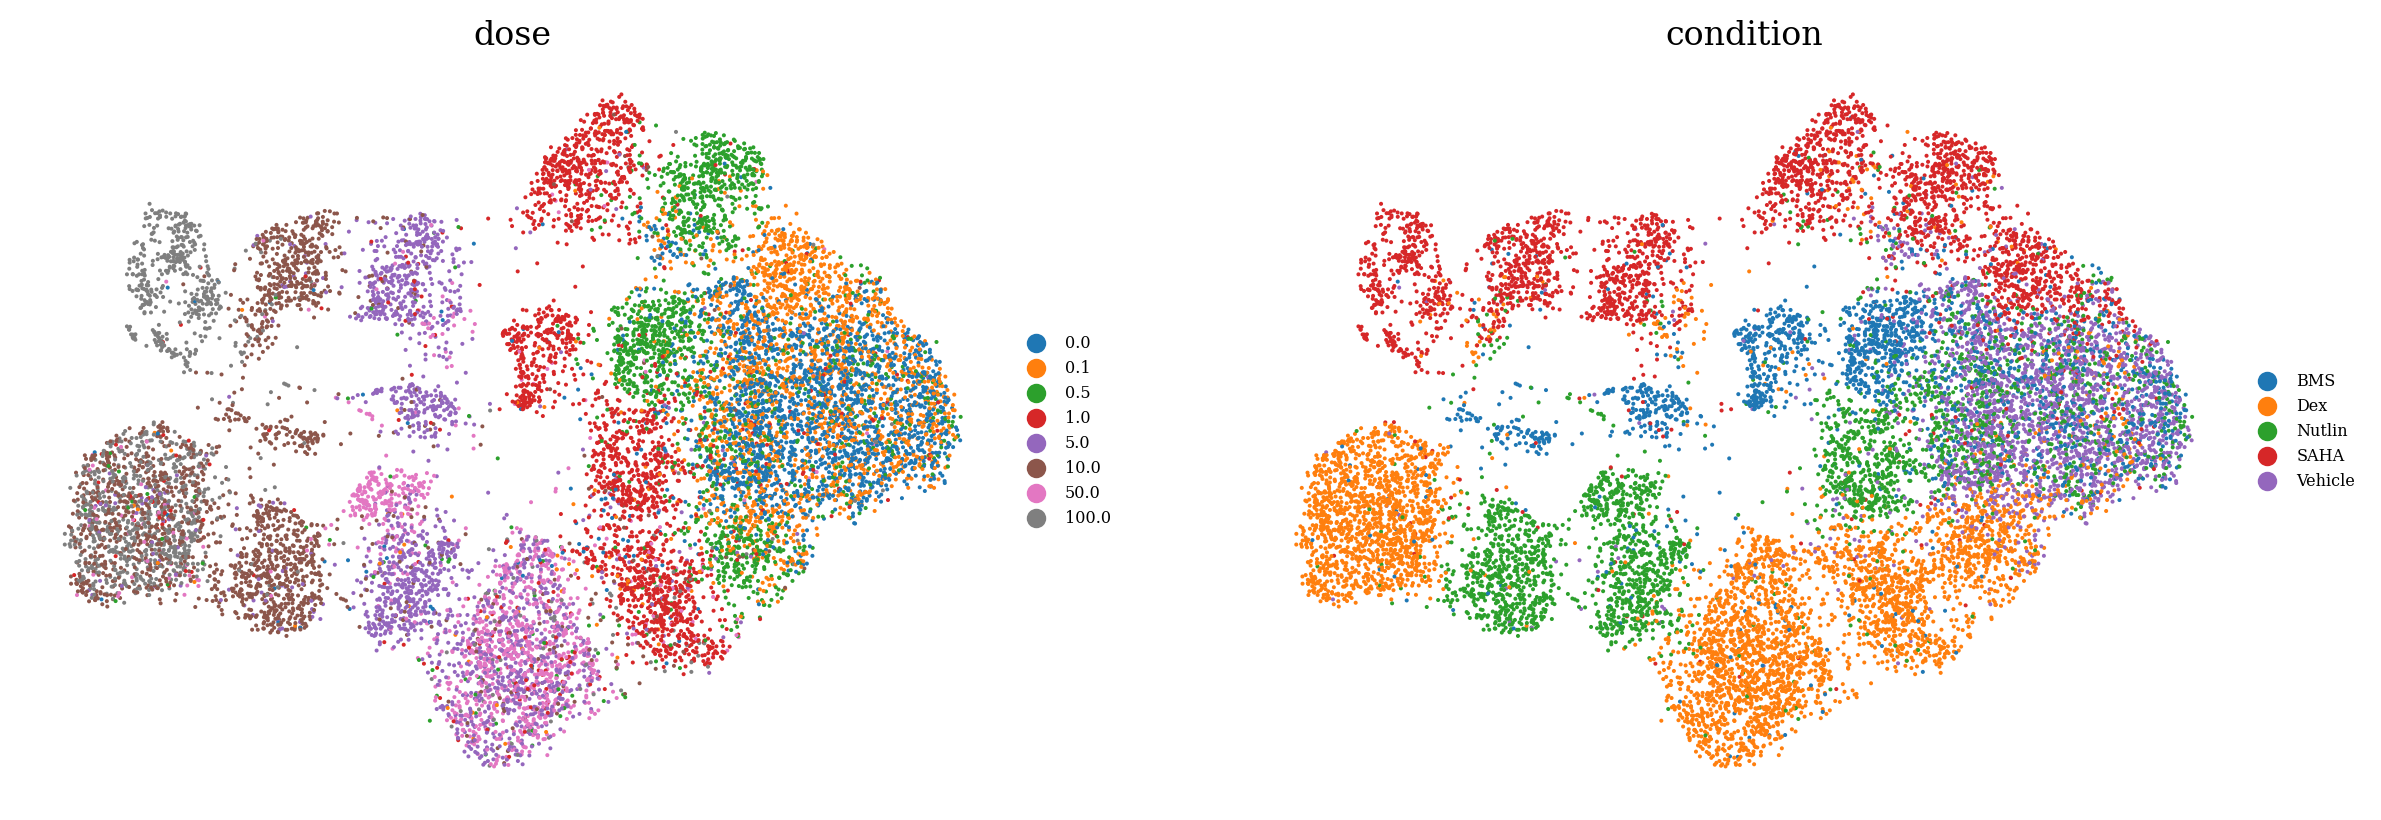

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [24]:
from tardis._disentanglementmanager import DisentanglementManager as DM

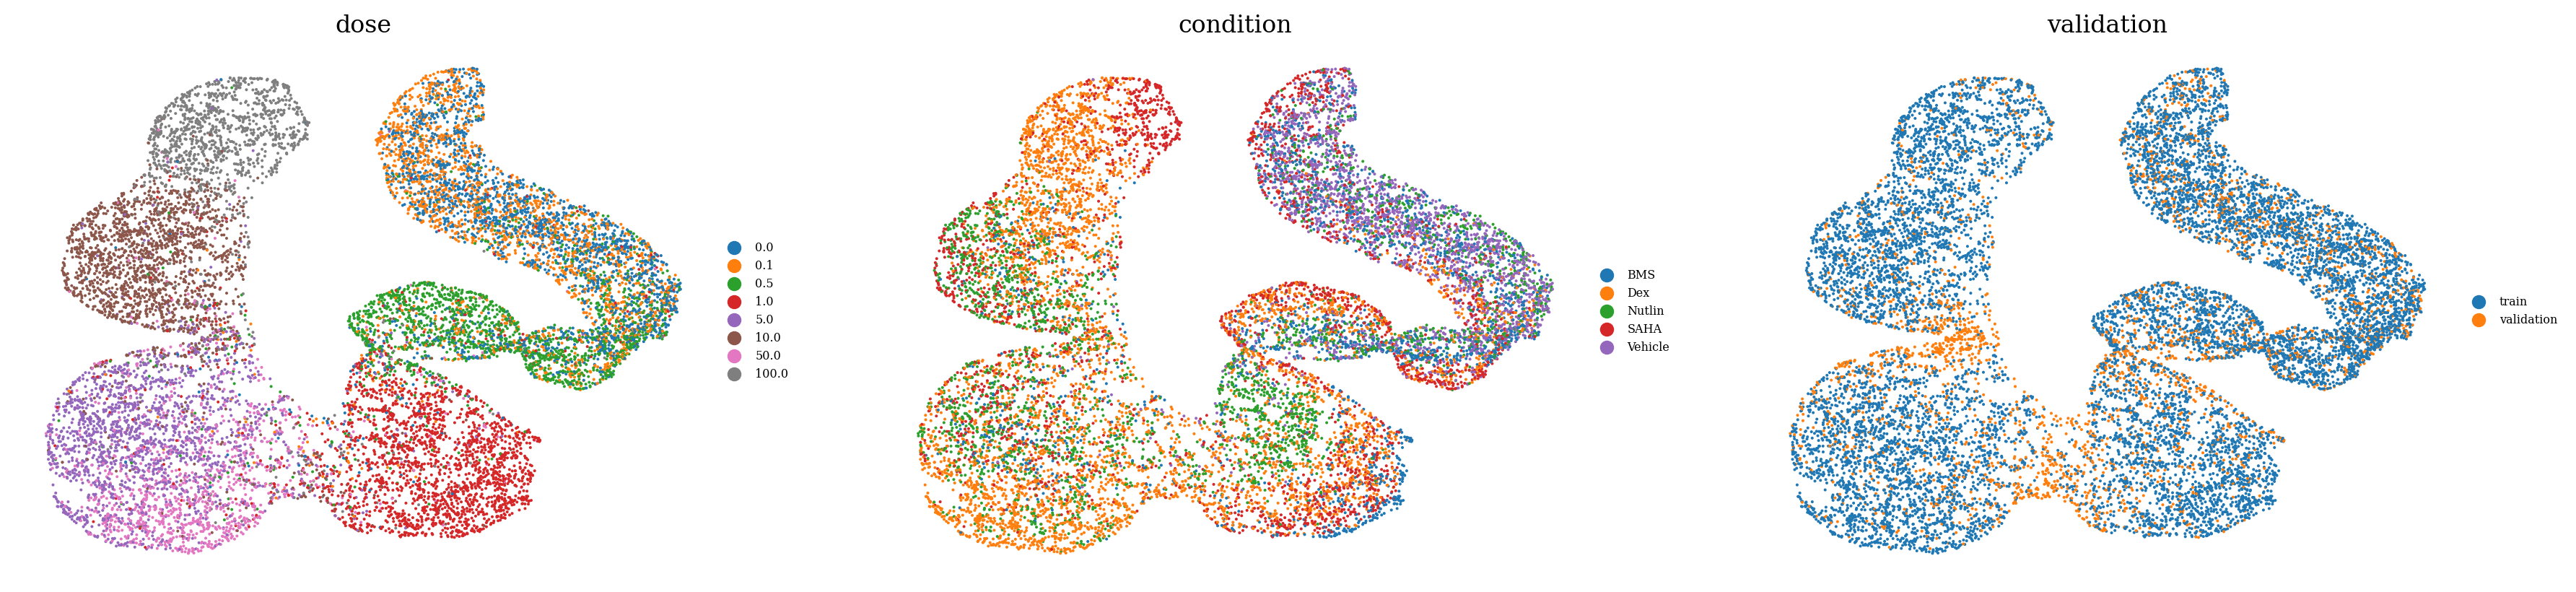

In [25]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [27]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


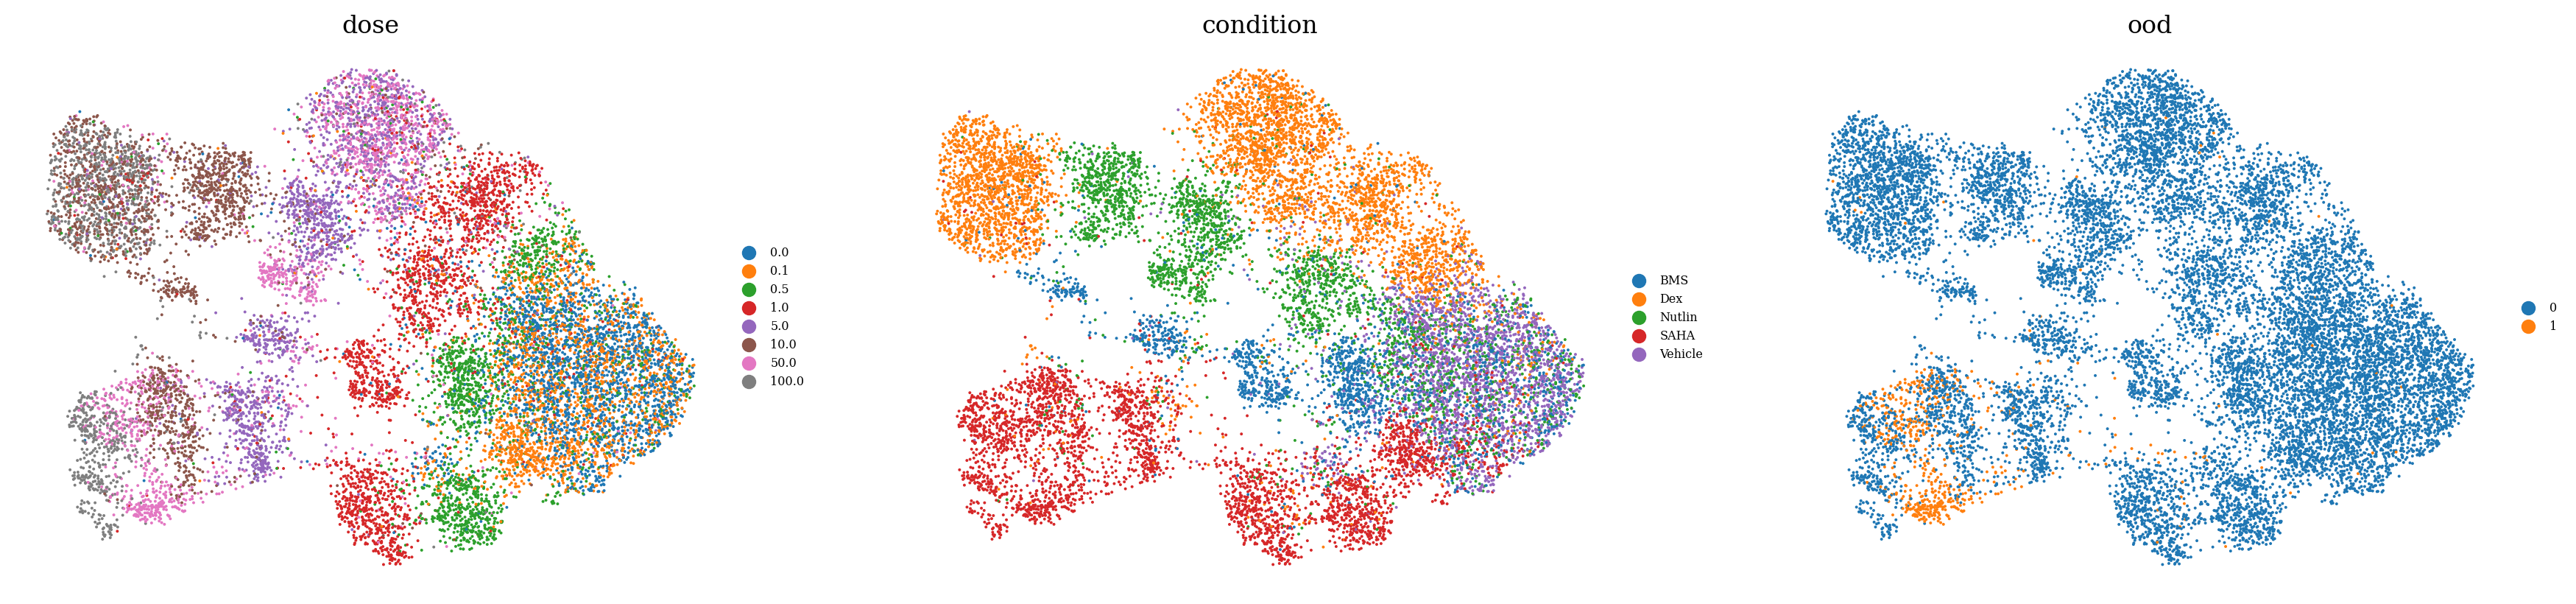

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [29]:
k = obs_key

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


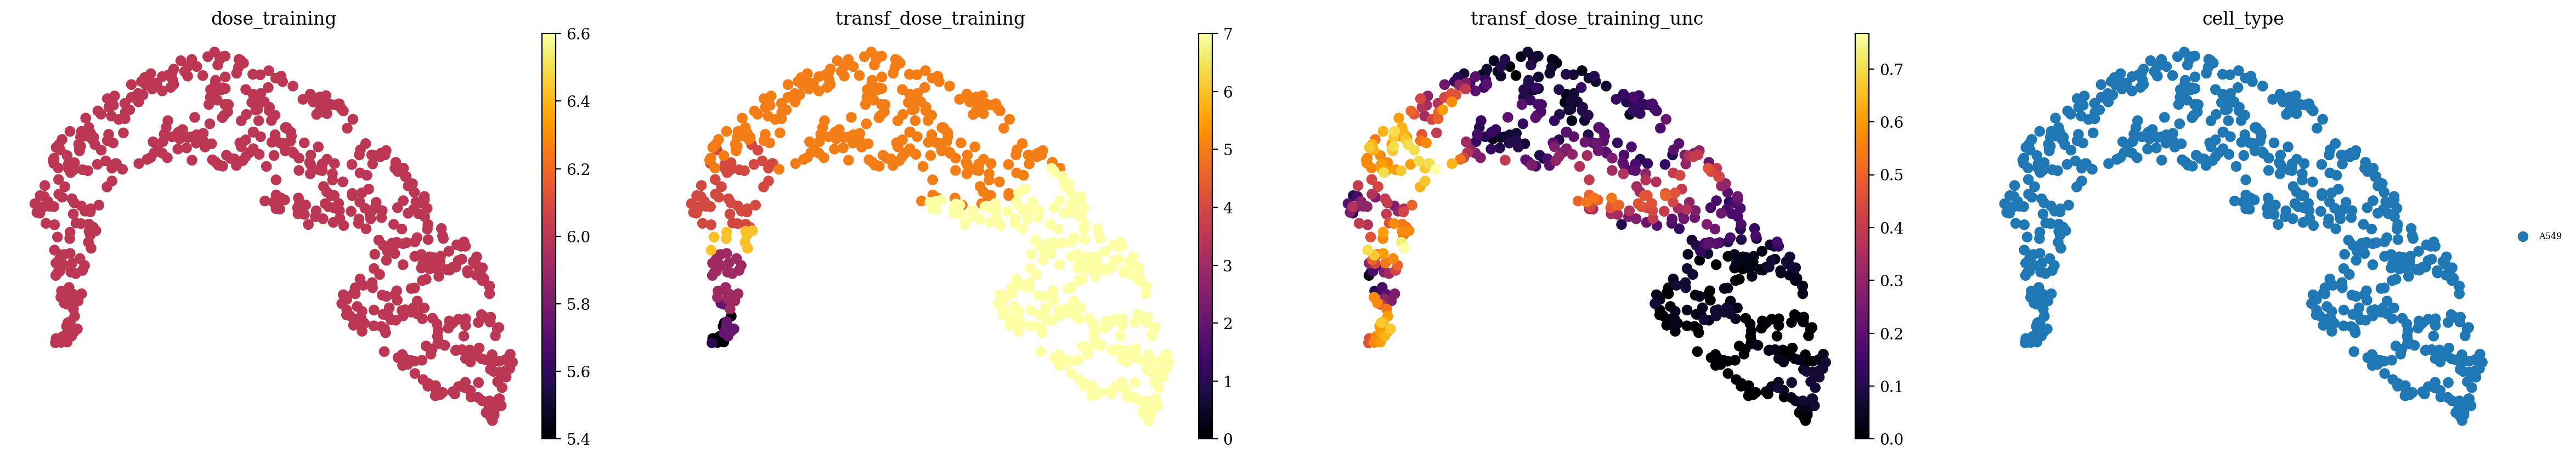

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.014900662251655629,
 'precision_macro': 0.125,
 'recall_macro': 0.0018625827814569536,
 'f1_score_macro': 0.0036704730831973896,
 'precision_micro': 0.014900662251655629,
 'recall_micro': 0.014900662251655629,
 'f1_score_micro': 0.014900662251655629,
 'precision_weighted': 1.0,
 'recall_weighted': 0.014900662251655629,
 'f1_score_weighted': 0.029363784665579117,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  8,   1,   9,  26,  48, 245,   9, 258],
        [  0,   0,   0,   0,   0,   0,   0,   0]])}

In [32]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [33]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.12882317196678145
